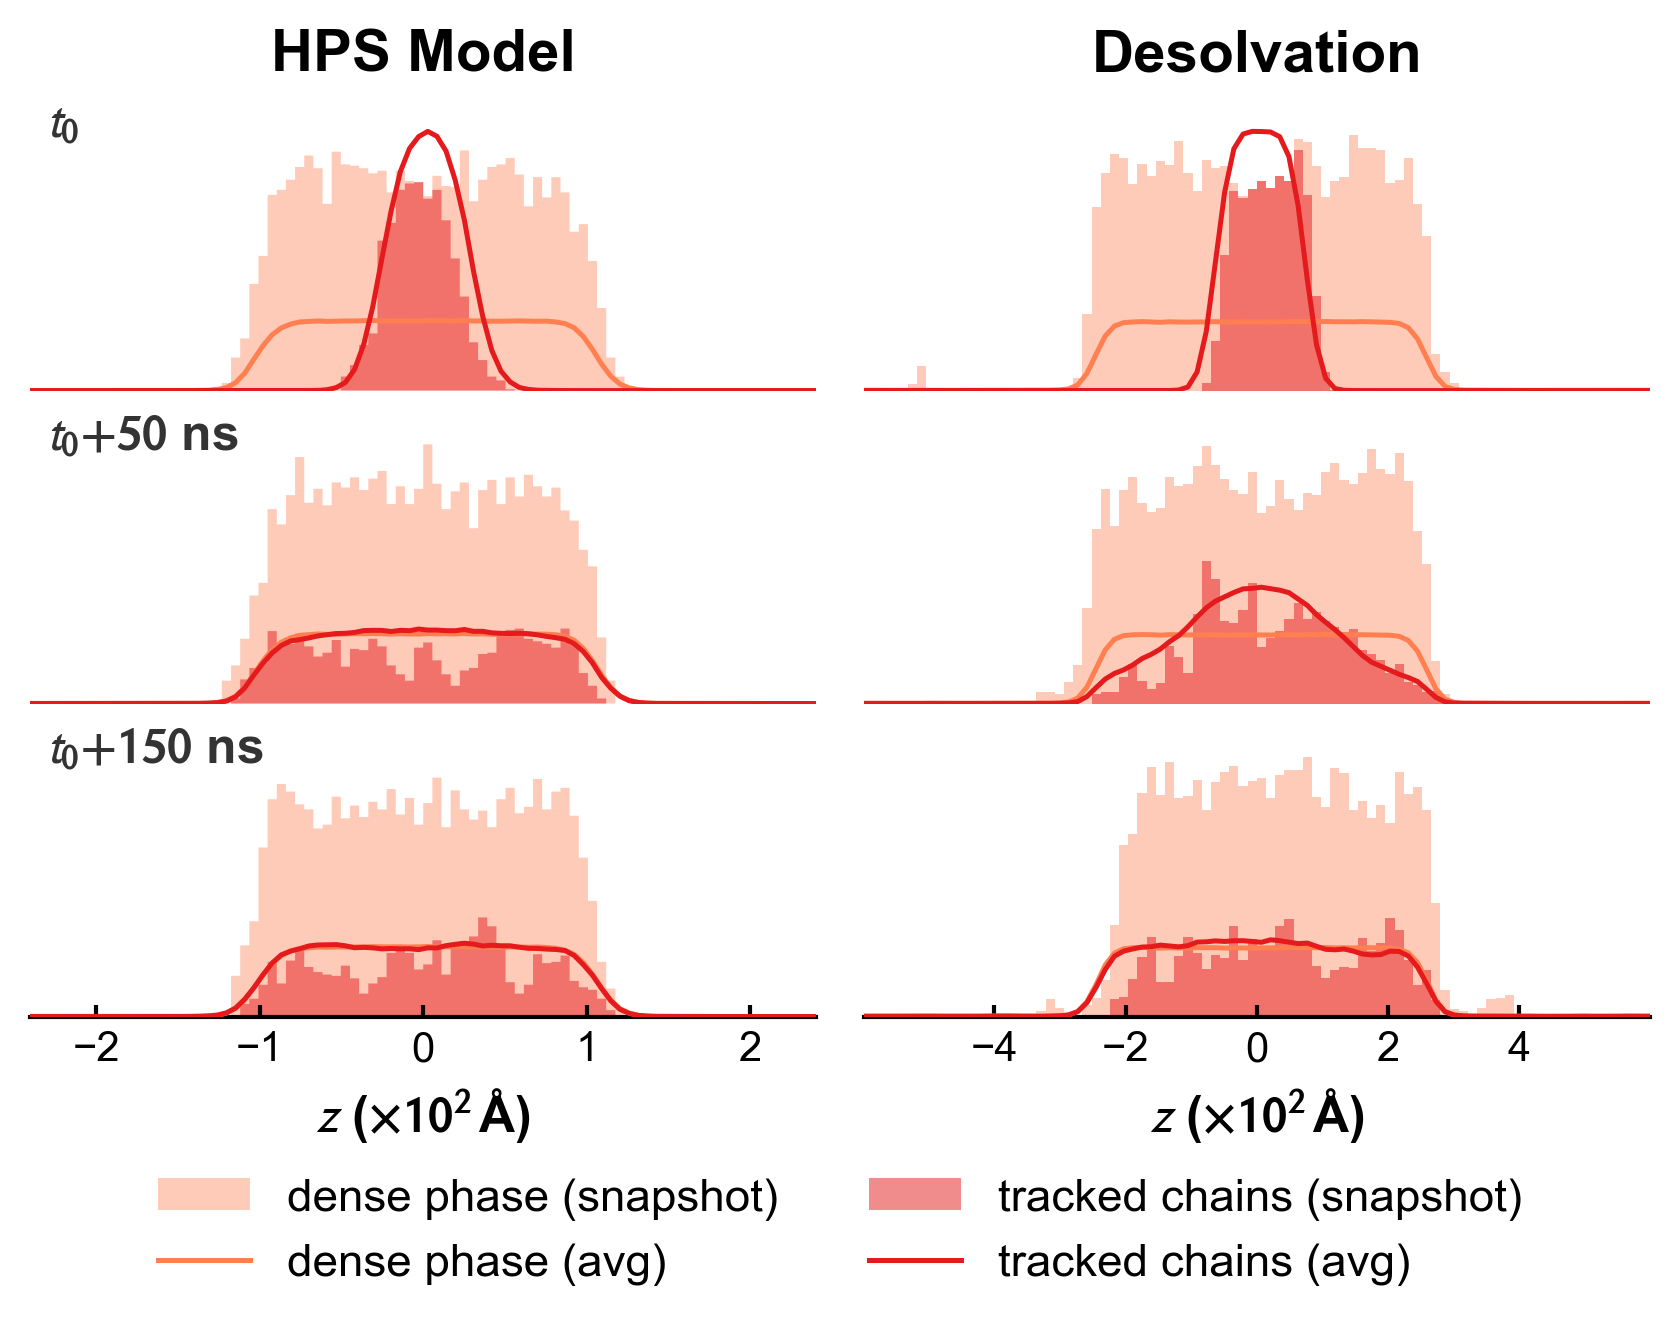

In [277]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import networkx as nx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Tstar_scale = 0.009935
density_scale = 1000 / (50*110) # mg/mL -> mM

def plot_diffusion_schematic(folder, ax_list):
    
    t_sim = '250'
    t_length1 = 50
    t_length2 = 150
    frame_start = 100

    color_dense = '#FF7F50'
    color_track = '#E41A1C'
    
    traj_dir = f'traj/poly50/{folder}/{t_sim}/{t_sim}'
    try:
        u = mda.Universe(f'{traj_dir}.gsd', f'{traj_dir}.dcd')
    except:
        print(f"Error loading {traj_dir}")
        return

    natoms = u.atoms.n_atoms
    nres = 50
    nchains = natoms // nres
    mass = u.atoms.masses
    box = u.dimensions
    lenz = box[2]
    zmax, zmin = lenz / 2, - lenz / 2
    nlen = len(u.trajectory)
    
    if folder == 'hps':
        nbins = 500
    else:
        nbins = 200 

    # -----------------------------------------------------------
    # 1. Data Collection
    # -----------------------------------------------------------
    
    snapshots_data = [] 
    
    averages_data = [[], [], []] 
    
    def process_frame(ts, idx_track):
        cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
        posz_all = ts.positions[:, 2] - cmassz
        # PBC wrap
        posz_all[posz_all < zmin] += lenz
        posz_all[posz_all > zmax] -= lenz
        
        posz_track = []
        for i in range(natoms):
            if int(i/nres) in idx_track:
                posz_track.append(posz_all[i])
        
        return list(posz_all), list(posz_track)

    ts = u.trajectory[frame_start]
    mc_z = []
    for i in range(nchains):
        mol = u.select_atoms('index %i:%i'%(i*50, (i+1)*50-1))
        mc_z.append(mol.center_of_mass()[2])

    dist_map = np.zeros((nchains, nchains))
    for i in range(nchains):
        for j in range(i, nchains):
            dist = min(abs(mc_z[i] - mc_z[j]), lenz - abs(mc_z[i] - mc_z[j]))
            dist_map[i, j] = dist
    dist_map += dist_map.T
    adj_map = np.where(dist_map<=5, 1, 0)
    net = nx.from_numpy_array(adj_map)
    idx_dense = list(max(nx.connected_components(net), key=len))
    mc_z_dense = np.array(mc_z).take(idx_dense)
    left_boundary = min(mc_z_dense)
    right_boundary = max(mc_z_dense)
    deltaz = 0.25 * (right_boundary - left_boundary)
    idx_track_initial = []
    for i in idx_dense:
        if abs(mc_z[i] - (left_boundary + right_boundary)/2) <= deltaz / 2:
            idx_track_initial.append(i)

    frames_indices = [frame_start, frame_start + t_length1, frame_start + t_length2]
    
    for f_idx in frames_indices:
        u.trajectory[f_idx]
        d_data, t_data = process_frame(u.trajectory[f_idx], idx_track_initial)
        snapshots_data.append([d_data, t_data])
        
    for i in range(3):
        averages_data[i] = [list(snapshots_data[i][0]), list(snapshots_data[i][1])]

    for frame in range(frame_start + 1, nlen - t_length2, 1):
        ts = u.trajectory[frame]
        
        mc_z_loop = []
        for i in range(nchains):
            mol = u.select_atoms('index %i:%i'%(i*50, (i+1)*50-1))
            mc_z_loop.append(mol.center_of_mass()[2])
            
        dist_map = np.zeros((nchains, nchains))
        for i in range(nchains):
            for j in range(i, nchains):
                dist = min(abs(mc_z_loop[i]-mc_z_loop[j]), lenz - abs(mc_z_loop[i]-mc_z_loop[j]))
                dist_map[i, j] = dist
        dist_map += dist_map.T
        adj_map = np.where(dist_map <= 5, 1, 0)
        net = nx.from_numpy_array(adj_map)
        idx_dense_loop = list(max(nx.connected_components(net), key=len))
        mc_z_dense = np.array(mc_z_loop).take(idx_dense_loop)
        right_boundary_loop = max(mc_z_dense)
        left_boundary_loop = min(mc_z_dense)

        idx_track_loop = []
        for i in idx_dense_loop:
            if abs(mc_z_loop[i] - (left_boundary_loop + right_boundary_loop)/2) <= deltaz / 2:
                idx_track_loop.extend(np.arange(i*nres, (i+1)*nres)) # 这里存的是 atom index? 原代码好像有点混淆
        
        idx_track_loop_chains = []
        for i in idx_dense_loop:
            if abs(mc_z_loop[i] - (left_boundary_loop + right_boundary_loop)/2) <= deltaz / 2:
                idx_track_loop_chains.append(i)

        d0, t0 = process_frame(u.trajectory[frame], idx_track_loop_chains)
        averages_data[0][0].extend(d0)
        averages_data[0][1].extend(t0)
        
        d1, t1 = process_frame(u.trajectory[frame + t_length1], idx_track_loop_chains)
        averages_data[1][0].extend(d1)
        averages_data[1][1].extend(t1)
        
        d2, t2 = process_frame(u.trajectory[frame + t_length2], idx_track_loop_chains)
        averages_data[2][0].extend(d2)
        averages_data[2][1].extend(t2)

    # -----------------------------------------------------------
    # 2. Scale Unification
    # -----------------------------------------------------------
    
    rng = [zmin*0.1, zmax*0.1]
    
    # Snapshot max (Counts)
    max_snap_val = 0
    for i in range(3):
        # Dense
        h_d, _ = np.histogram(np.array(snapshots_data[i][0])*0.1, bins=nbins, range=rng)
        max_snap_val = max(max_snap_val, np.max(h_d))
        # Tracked
        # h_t, _ = np.histogram(np.array(snapshots_data[i][1])*0.1, bins=nbins, range=rng)
        # max_snap_val = max(max_snap_val, np.max(h_t))
    
    ylim_snapshot = [0, max_snap_val * 1.15]
    
    max_avg_val = 0
    for i in range(3):
        # Dense
        h_d, _ = np.histogram(np.array(averages_data[i][0])*0.1, bins=nbins, range=rng, density=True)
        max_avg_val = max(max_avg_val, np.max(h_d))
        # Tracked
        h_t, _ = np.histogram(np.array(averages_data[i][1])*0.1, bins=nbins, range=rng, density=True)
        max_avg_val = max(max_avg_val, np.max(h_t))
        
    ylim_average = [0, max_avg_val * 1.15]

    # -----------------------------------------------------------
    # 3. Plotting
    # -----------------------------------------------------------
    
    xlim = (right_boundary - left_boundary) * 0.1 * 1.1
    leftx, rightx = -xlim, xlim
    
    def plot_step_filled(ax, data, bins, rng, color, alpha):
        counts, bin_edges = np.histogram(data, bins=bins, range=rng)
        centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.fill_between(centers, 0, counts, step='mid', color=color, alpha=alpha, linewidth=0)

    def plot_avg_curve_twin(ax, data_dense, data_track, bins, rng, y_limits):
        ax_twin = ax.twinx()
        hist_d, bin_edges = np.histogram(data_dense, bins=bins, range=rng, density=True)
        hist_t, _ = np.histogram(data_track, bins=bins, range=rng, density=True)
        centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        ax_twin.plot(centers, hist_d, color=color_dense, linewidth=1.2, alpha=1.0)
        ax_twin.plot(centers, hist_t, color=color_track, linewidth=1.2, alpha=1.0)
        
        ax_twin.set_ylim(y_limits)
        
        ax_twin.set_yticks([])
        ax_twin.spines['top'].set_visible(False)
        ax_twin.spines['right'].set_visible(False)
        ax_twin.spines['left'].set_visible(False)
        ax_twin.spines['bottom'].set_visible(False)

    for i in range(3):
        ax = ax_list[i]
        
        snap_d = np.array(snapshots_data[i][0]) * 0.1
        snap_t = np.array(snapshots_data[i][1]) * 0.1
        plot_step_filled(ax, snap_d, nbins, rng, color_dense, 0.4)
        plot_step_filled(ax, snap_t, nbins, rng, color_track, 0.5)
        
        ax.set_ylim(ylim_snapshot)
        
        avg_d = np.array(averages_data[i][0]) * 0.1
        avg_t = np.array(averages_data[i][1]) * 0.1
        plot_avg_curve_twin(ax, avg_d, avg_t, nbins, rng, ylim_average)
        
        ax.set_xlim(leftx, rightx)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        
        if i == 2:
            ax.spines['bottom'].set_visible(True)
            ax.spines['bottom'].set_linewidth(1.0)
            ax.tick_params(axis='x', direction='in', length=3, width=1.0)
            ax.set_xlabel(r'$\boldsymbol{z}$ ($\bf{\times 10^2}\,\mathregular{\AA}$)', fontsize=12, fontweight='bold')
        else:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])

fig, ax = plt.subplots(3, 2, figsize=[6.0, 4.0], facecolor='w', dpi=300)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'

plot_diffusion_schematic('hps', ax[:, 0])
plot_diffusion_schematic('des_0.20_0.06_0.02', ax[:, 1])

ax[0, 0].set_title('HPS Model', fontsize=14, pad=5, fontweight='bold')
ax[0, 1].set_title('Desolvation', fontsize=14, pad=5, fontweight='bold')

time_labels = [r'$\boldsymbol{t}_\mathbf{0}$', r'$\boldsymbol{t}_\mathbf{0}\mathbf{ + 50}$ ns', r'$\boldsymbol{t}_\mathbf{0}\mathbf{ + 150}$ ns']
for i in range(3):
    ax[i, 0].text(0.02, 0.85, time_labels[i], fontsize=12, 
                  transform=ax[i, 0].transAxes, color='#333333', weight='bold')

color_dense = '#FF7F50'
color_track = '#E41A1C'
legend_elements = [
    Patch(facecolor=color_dense, alpha=0.4, label='dense phase (snapshot)'),
    Line2D([0], [0], color=color_dense, lw=1.2, label='dense phase (avg)'),
    Patch(facecolor=color_track, alpha=0.5, label='tracked chains (snapshot)'),
    Line2D([0], [0], color=color_track, lw=1.2, label='tracked chains (avg)')
]

fig.legend(handles=legend_elements, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 0.05), 
           ncol=2, frameon=False, fontsize=11)

plt.subplots_adjust(top=0.92, bottom=0.15, left=0.05, right=0.95, hspace=0.05, wspace=0.06)

plt.savefig("../../figures/diffusion/new_plot/schematic.svg", format="svg", bbox_inches='tight')
plt.show()

Eb=0.06: K=0.4358, alpha=0.8971
Eb=0.08: K=0.4930, alpha=0.9163
Eb=0.10: K=0.6569, alpha=0.8909
Eb=0.12: K=0.8078, alpha=0.9166
Eb=0.14: K=1.1767, alpha=0.9229


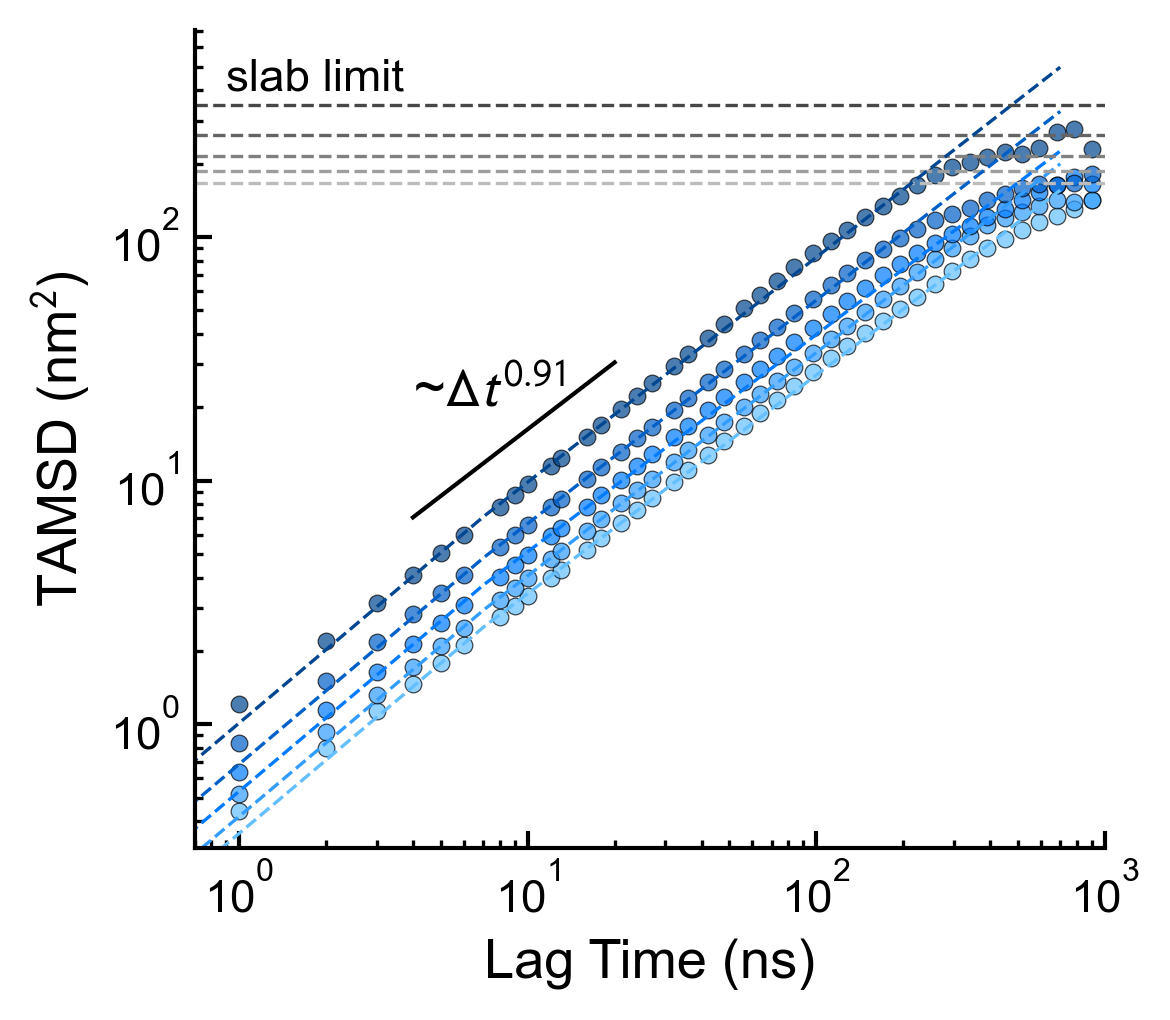

In [ ]:
import os
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit

# =============================================================================
# 1. Style Settings (Top-Tier Style)
# =============================================================================
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0 
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['mathtext.default'] = 'it'

def apply_pub_style(ax, remove_spines=True):
    """应用顶刊出版级绘图风格"""
    ax.minorticks_on()
    ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
    
    # 增加刻度长度
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2)
    
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)

# =============================================================================
# 2. Calculation Logic (Refactored to return data)
# =============================================================================

def calc_slab_properties(traj, nbins=500):
    
    scale = 10.0
    xyz = traj.xyz * scale
    L = traj.unitcell_lengths[0] * scale
    Lx, Ly, Lz = L[0], L[1], L[2]
    
    com_z = np.mean(xyz[:, :, 2], axis=1)
    shift = (Lz / 2.0) - com_z
    xyz[:, :, 2] = (xyz[:, :, 2] + shift[:, None]) % Lz
    
    z_all = xyz[:, :, 2].ravel()
    hist, edges = np.histogram(z_all, bins=nbins, range=(0, Lz))
    z = (edges[:-1] + edges[1:]) / 2
    rho = hist / (traj.n_frames * Lx * Ly * (Lz / nbins))
    
    rho_max = np.max(rho)
    rho_min = np.min(rho)
    if rho_max == 0 or (rho_max - rho_min) < 0.25 * rho_max:
        return None

    def slab_fit(z, rho_l, rho_v, z1, z2, w):
        return rho_v + 0.5 * (rho_l - rho_v) * (np.tanh((z - z1)/w) - np.tanh((z - z2)/w))
    
    p0 = [rho_max, rho_min, Lz*0.25, Lz*0.75, 1.0]
    try:
        popt, _ = curve_fit(slab_fit, z, rho, p0=p0, maxfev=5000)
        boundaries = sorted([popt[2], popt[3]])
    except:
        return None
    return boundaries

def calculate_dense_tamsd_data(dcd_file, gsd_file, chain_length=50):
    
    try:
        traj = md.load(dcd_file, top=gsd_file)
    except Exception as e:
        print(f"Error loading {dcd_file}: {e}")
        return None
        
    n_frames = traj.n_frames
    boundaries = calc_slab_properties(traj)
    if boundaries is None:
        return None
    z_min, z_max = boundaries

    n_chains = traj.n_atoms // chain_length
    scale = 10.0
    Lz = traj.unitcell_lengths[0, 2] * scale
    xyz = traj.xyz * scale 
    z_atoms = xyz[:, :, 2]
    z_chain_coms = z_atoms.reshape(n_frames, n_chains, chain_length).mean(axis=2)
    sys_com_z = np.mean(z_atoms, axis=1)
    shift = (Lz / 2.0) - sys_com_z
    z_filter = (z_chain_coms + shift[:, None]) % Lz 
    
    out_of_dense = ~((z_filter > z_min) & (z_filter < z_max))
    cum_out = np.cumsum(out_of_dense.astype(np.int32), axis=0)

    # PBC unwrap
    dz = z_chain_coms[1:] - z_chain_coms[:-1]
    dz = dz - Lz * np.round(dz / Lz)
    unwrapped_z = np.zeros_like(z_chain_coms)
    unwrapped_z[0] = z_chain_coms[0]
    unwrapped_z[1:] = z_chain_coms[0] + np.cumsum(dz, axis=0)
    slab_drift = np.mean(unwrapped_z, axis=1, keepdims=True)
    z_calc = unwrapped_z - slab_drift
    
    # TAMSD
    max_lag = int(n_frames // 2 * 1.8)
    lag_times = np.unique(np.logspace(0, np.log10(max_lag), num=50).astype(int))
    tamsd_values = []
    
    for lag in lag_times:
        mask_start = (z_filter[:-lag] > z_min) & (z_filter[:-lag] < z_max)
        continuous_check = (cum_out[lag:] - cum_out[:-lag]) == 0
        valid_mask = mask_start & continuous_check
        if np.any(valid_mask):
            diff = z_calc[lag:] - z_calc[:-lag]
            tamsd_values.append(np.mean(diff[valid_mask] ** 2))
        else:
            tamsd_values.append(np.nan)
            
    tamsd_values = np.array(tamsd_values)
    valid_idx = ~np.isnan(tamsd_values)
    if np.sum(valid_idx) < 3:
        return None
    
    # Fitting
    time_ns = lag_times * 1.0
    
    log_t = np.log(lag_times[valid_idx])
    log_msd = np.log(tamsd_values[valid_idx])
    
    slopes = np.diff(log_msd) / np.diff(log_t)
    cutoff_idx = len(log_t)
    for i, slope in enumerate(slopes):
        if i > 2 and (slope < 0.5 or slope > 1.2):
            cutoff_idx = i + 1
            break
            
    log_t_fit = log_t[:cutoff_idx]
    log_msd_fit = log_msd[:cutoff_idx]
    
    if len(log_t_fit) < 3:
        return None
    
    alpha, intercept = np.polyfit(log_t_fit, log_msd_fit, 1)
    K_fit = np.exp(intercept)
    
    # Data for fit line
    fit_time = np.exp(log_t_fit)
    fit_time = np.linspace(0, 700, 100)
    fit_vals = K_fit * fit_time**alpha
    
    return time_ns, tamsd_values, fit_time, fit_vals, K_fit, alpha

# =============================================================================
# 3. Main Plotting (With New Style)
# =============================================================================

eb_list = ['0.06', '0.08', '0.10', '0.12', '0.14']
cmap_list = ["#6EC6FF", "#007BFF", "#004085"]
gray_list = ["#C2C2C2", "#808080", "#414141"]
cmap_obj = LinearSegmentedColormap.from_list("academic_blue", cmap_list, N=256)
cmap_gray = LinearSegmentedColormap.from_list("gray_scale", gray_list, N=256)
colors = cmap_obj(np.linspace(0.05, 0.95, len(eb_list)))
colors_gray = cmap_gray(np.linspace(0.05, 0.95, len(eb_list)))

fig, ax = plt.subplots(figsize=(4, 3.5), dpi=300)
apply_pub_style(ax)

for i, eb in enumerate(eb_list):
    dcd_path = f"traj/poly50/des_0.20_{eb}_0.02/150/150.dcd"
    gsd_path = f"traj/poly50/des_0.20_{eb}_0.02/150/150.gsd"
    
    if not os.path.exists(dcd_path):
        print(f"Skipping {eb}, file not found.")
        continue

    result = calculate_dense_tamsd_data(dcd_path, gsd_path)
    
    if result is not None:
        time_ns, tamsd, fit_t, fit_v, K, alpha = result
        color = colors[i]
        
        ax.loglog(time_ns, tamsd, 'o', 
                  markersize=4, 
                  color=color, 
                  markeredgecolor='k', 
                  markeredgewidth=0.3,
                  alpha=0.7, 
                  label=fr'$\epsilon_\mathregular{{b}}={eb}$',
                  zorder=1)
        
        ax.loglog(fit_t, fit_v, '--', 
                  color=color, 
                  linewidth=0.8, 
                  zorder=2)
        
        print(f"Eb={eb}: K={K:.4f}, alpha={alpha:.4f}")

        zmin, zmax = calc_slab_properties(md.load(dcd_path, top=gsd_path))
        Lz = (zmax - zmin)/2.5
        ax.axhline(Lz**2, ls='--', color=colors_gray[i], lw=0.8)

slop_x = np.array([4, 20])
slop_y = 2 * slop_x**0.91
ax.loglog(slop_x, slop_y, color='k', lw=1.0)
ax.text(4, 20, r'~$\Delta t^{0.91}$', fontsize=13)
ax.text(0.9, 400, 'slab limit', fontsize=11, rotation=0)

ax.set_xlim(0.7, 1000)
ax.set_xlabel('Lag Time (ns)', fontsize=13)
ax.set_ylabel(r'TAMSD (nm$^2$)', fontsize=13)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
# legend = ax.legend(fontsize=9, frameon=False, loc='best')

plt.tight_layout()
plt.savefig("../../figures/diffusion/new_plot/tamsd.svg", format="svg", bbox_inches='tight')
plt.show()

In [6]:
import os
import numpy as np
import mdtraj as md
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
from matplotlib import cm, colors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit

# ==========================================
# 1. Physics Calculation Functions
# ==========================================

def calc_slab_properties(traj, nbins=500):
    scale = 10.0
    xyz = traj.xyz * scale
    L = traj.unitcell_lengths[0] * scale
    Lx, Ly, Lz = L[0], L[1], L[2]
    
    com_z = np.mean(xyz[:, :, 2], axis=1)
    shift = (Lz / 2.0) - com_z
    xyz[:, :, 2] = (xyz[:, :, 2] + shift[:, None]) % Lz
    
    z_all = xyz[:, :, 2].ravel()
    hist, edges = np.histogram(z_all, bins=nbins, range=(0, Lz))
    z = (edges[:-1] + edges[1:]) / 2
    rho = hist / (traj.n_frames * Lx * Ly * (Lz / nbins))
    
    rho_max = np.max(rho)
    rho_min = np.min(rho)
    if rho_max == 0 or (rho_max - rho_min) < 0.25 * rho_max:
        return None

    def slab_fit(z, rho_l, rho_v, z1, z2, w):
        return rho_v + 0.5 * (rho_l - rho_v) * (np.tanh((z - z1)/w) - np.tanh((z - z2)/w))
    
    p0 = [rho_max, rho_min, Lz*0.25, Lz*0.75, 1.0]
    try:
        popt, _ = curve_fit(slab_fit, z, rho, p0=p0, maxfev=5000)
        boundaries = sorted([popt[2], popt[3]])
    except:
        return None
    return boundaries

def calculate_dense_tamsd(dcd_file, gsd_file, chain_length=50):
    try:
        traj = md.load(dcd_file, top=gsd_file)
    except:
        return np.nan, np.nan
        
    n_frames = traj.n_frames
    boundaries = calc_slab_properties(traj)
    if boundaries is None:
        return np.nan, np.nan
    z_min, z_max = boundaries

    n_chains = traj.n_atoms // chain_length
    scale = 10.0
    Lz = traj.unitcell_lengths[0, 2] * scale
    xyz = traj.xyz * scale 
    z_atoms = xyz[:, :, 2]
    z_chain_coms = z_atoms.reshape(n_frames, n_chains, chain_length).mean(axis=2)
    sys_com_z = np.mean(z_atoms, axis=1)
    shift = (Lz / 2.0) - sys_com_z
    z_filter = (z_chain_coms + shift[:, None]) % Lz 
    
    out_of_dense = ~((z_filter > z_min) & (z_filter < z_max))
    cum_out = np.cumsum(out_of_dense.astype(np.int32), axis=0)

    # PBC unwrap
    dz = z_chain_coms[1:] - z_chain_coms[:-1]
    dz = dz - Lz * np.round(dz / Lz)
    unwrapped_z = np.zeros_like(z_chain_coms)
    unwrapped_z[0] = z_chain_coms[0]
    unwrapped_z[1:] = z_chain_coms[0] + np.cumsum(dz, axis=0)
    slab_drift = np.mean(unwrapped_z, axis=1, keepdims=True)
    z_calc = unwrapped_z - slab_drift
    
    # TAMSD
    max_lag = n_frames // 2
    lag_times = np.unique(np.logspace(0, np.log10(max_lag), num=50).astype(int))
    tamsd_values = []
    
    for lag in lag_times:
        mask_start = (z_filter[:-lag] > z_min) & (z_filter[:-lag] < z_max)
        continuous_check = (cum_out[lag:] - cum_out[:-lag]) == 0
        valid_mask = mask_start & continuous_check
        if np.any(valid_mask):
            diff = z_calc[lag:] - z_calc[:-lag]
            tamsd_values.append(np.mean(diff[valid_mask] ** 2))
        else:
            tamsd_values.append(np.nan)
            
    tamsd_values = np.array(tamsd_values)
    valid_idx = ~np.isnan(tamsd_values)
    if np.sum(valid_idx) < 3:
        return np.nan, np.nan
    
    log_t = np.log(lag_times[valid_idx])
    log_msd = np.log(tamsd_values[valid_idx])
    
    slopes = np.diff(log_msd) / np.diff(log_t)
    cutoff_idx = len(log_t)
    for i, slope in enumerate(slopes):
        if i > 2 and (slope < 0.5 or slope > 1.2):
            cutoff_idx = i + 1
            break
            
    log_t_fit = log_t[:cutoff_idx]
    log_msd_fit = log_msd[:cutoff_idx]
    
    if len(log_t_fit) < 3:
        return np.nan, np.nan
    
    alpha, intercept = np.polyfit(log_t_fit, log_msd_fit, 1)
    K_fit = np.exp(intercept)
    
    return K_fit, alpha

def calculate_phase_density(dcd_file, gsd_file, data_folder, T_sim):
    npy_path = f"{data_folder}{T_sim}_dp.npy"
    if os.path.exists(npy_path):
        rhoave = np.load(npy_path)
    else:
        return 0, 0
        
    rho_max, rho_min = max(rhoave), min(rhoave)
    rho_hd = rhoave[rhoave >= rho_max * 0.95]
    rho_ld = rhoave[rhoave <= rho_min + 50]
    
    val_hd = np.mean(rho_hd) if len(rho_hd) > 0 else 0
    val_ld = np.mean(rho_ld) if len(rho_ld) > 0 else 0
    return val_hd, val_ld

# ==========================================
# 2. Data Collection (Modified to collect alpha)
# ==========================================

def collect_all_data():
    """Iterates through folders and collects plot data, including alpha."""
    data = {
        'eb': {},       
        'ew': {},       
        # Modified structure to include alpha list
        'scat_des': {'rho': [], 'diff': [], 'temp': [], 'alpha': []},
        'scat_hps': {'rho': [], 'diff': [], 'temp': [], 'alpha': []}
    }
    
    # 1. Collect Eb dependence
    temp_list_eb = [150, 160, 170, 180]
    params_eb = ['0.06', '0.08', '0.10', '0.12', '0.14']
    for temp in temp_list_eb:
        k_vals, x_vals = [], []
        for p in params_eb:
            dcd = f"traj/poly50/des_0.20_{p}_0.02/{temp}/{temp}.dcd"
            gsd = f"traj/poly50/des_0.20_{p}_0.02/{temp}/{temp}.gsd"
            if os.path.exists(dcd):
                k, a = calculate_dense_tamsd(dcd, gsd)
                if not np.isnan(k):
                    k_vals.append(k)
                    x_vals.append(float(p))
        data['eb'][temp] = (x_vals, k_vals)

    # 2. Collect Ew dependence
    temp_list_ew = [130, 140, 150, 160]
    params_ew = ['0.00', '0.01', '0.02', '0.03', '0.04']
    for temp in temp_list_ew:
        k_vals, x_vals = [], []
        for p in params_ew:
            dcd = f"traj/poly50/des_0.20_0.12_{p}/{temp}/{temp}.dcd"
            gsd = f"traj/poly50/des_0.20_0.12_{p}/{temp}/{temp}.gsd"
            if os.path.exists(dcd):
                k, a = calculate_dense_tamsd(dcd, gsd)
                if not np.isnan(k):
                    k_vals.append(k)
                    x_vals.append(float(p))
        data['ew'][temp] = (x_vals, k_vals)

    # 3. Collect Scatter Data (Desolvation)
    base_dir = 'traj/poly50/'
    if os.path.exists(base_dir):
        folders = sorted([f for f in os.listdir(base_dir) if 'des' in f])
        for folder in folders:
            for T in range(0, 1000, 10):
                dcd = f"{base_dir}{folder}/{T}/{T}.dcd"
                gsd = f"{base_dir}{folder}/{T}/{T}.gsd"
                data_path = f"data/poly50/{folder}/"
                
                if not os.path.exists(dcd): continue
                
                rho_d, rho_l = calculate_phase_density(dcd, gsd, data_path, T)
                if abs(rho_d - rho_l) <= 50: continue
                
                k, alpha = calculate_dense_tamsd(dcd, gsd)
                if not np.isnan(k) and k <= 5:
                    data['scat_des']['rho'].append(rho_d)
                    data['scat_des']['diff'].append(k)
                    data['scat_des']['temp'].append(T)
                    data['scat_des']['alpha'].append(alpha) # Collect alpha

    # 4. Collect Scatter Data (HPS)
    hps_dir = 'traj/poly50/hps/'
    if os.path.exists(hps_dir):
        for T in range(0, 1000, 10):
            dcd = f"{hps_dir}{T}/{T}.dcd"
            gsd = f"{hps_dir}{T}/{T}.gsd"
            data_path = "data/poly50/hps/"
            
            if not os.path.exists(dcd): continue
            
            rho_d, rho_l = calculate_phase_density(dcd, gsd, data_path, T)
            if abs(rho_d - rho_l) <= 50: continue
            
            k, alpha = calculate_dense_tamsd(dcd, gsd)
            if not np.isnan(k) and k <= 5:
                data['scat_hps']['rho'].append(rho_d)
                data['scat_hps']['diff'].append(k)
                data['scat_hps']['temp'].append(T)
                data['scat_hps']['alpha'].append(alpha) # Collect alpha
                
    return data

plot_data = collect_all_data()

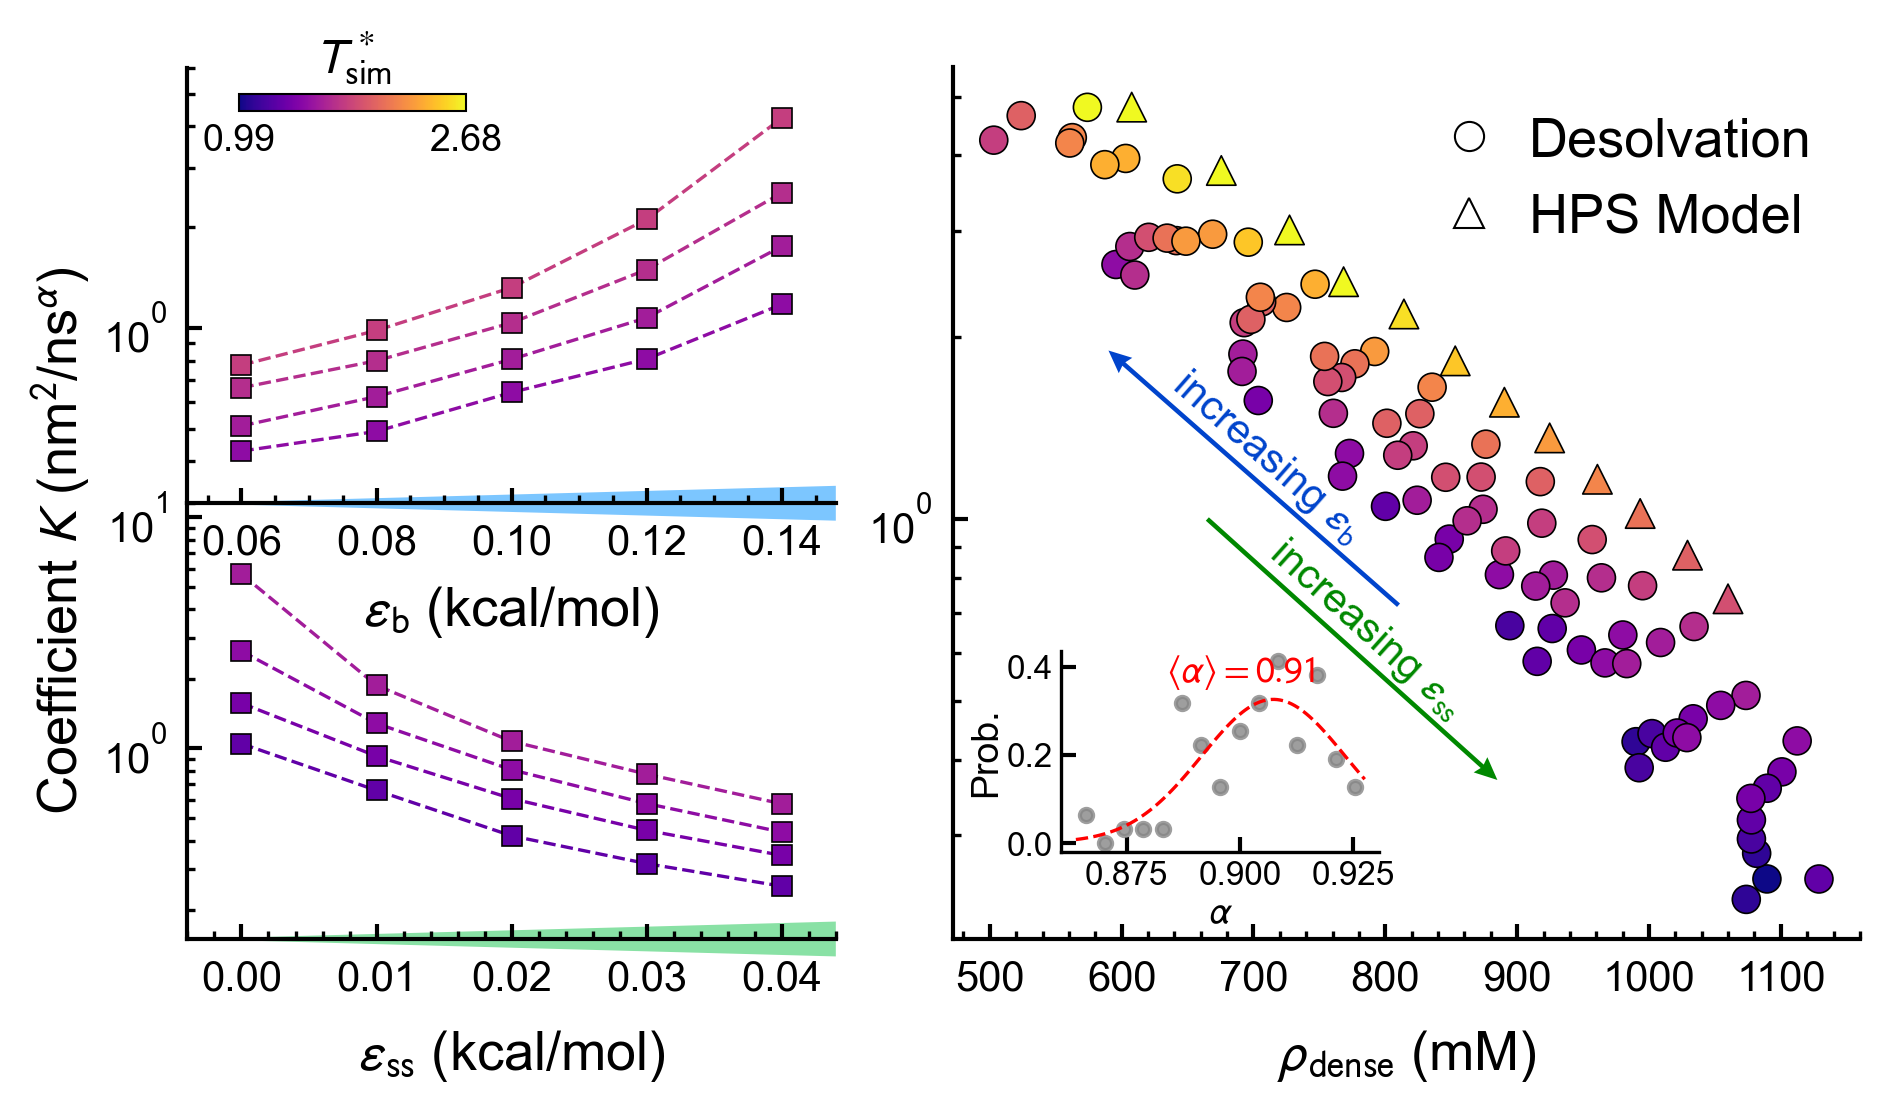

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec
from matplotlib import cm, colors
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from scipy.optimize import curve_fit

def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def add_parallel_arrow_label(ax, start, end, text, color='black', fontsize=10):
    
    x_start, y_start = start
    x_end, y_end     = end
    
    pos_start_pix = ax.transData.transform((x_start, y_start))
    pos_end_pix   = ax.transData.transform((x_end, y_end))
    dx_pix = pos_end_pix[0] - pos_start_pix[0]
    dy_pix = pos_end_pix[1] - pos_start_pix[1]
    angle_deg = np.degrees(np.arctan2(dy_pix, dx_pix))
    if x_start > x_end:
        angle_deg += 180

    ax.quiver(x_start, y_start, 
                  x_end - x_start, y_end - y_start, 
                  angles='xy', scale_units='xy', scale=1,
                  color=color, 
                  width=0.005,
                  headwidth=4.5,
                  headlength=5.0,
                  headaxislength=4.5,
                  zorder=20)

    text_x = x_start + (x_end - x_start) * 0.5
    log_y_mid = (np.log(y_start) + np.log(y_end)) / 2
    text_y = np.exp(log_y_mid)*1.02

    ax.text(text_x, text_y, text, 
                rotation=angle_deg,
                rotation_mode='anchor',
                fontsize=fontsize, color=color,
                ha='center', va='bottom',
                zorder=21)

def plot_combined_figure(data):
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams['xtick.major.width'] = 1.0
    plt.rcParams['ytick.major.width'] = 1.0
    plt.rcParams['xtick.minor.width'] = 0.8
    plt.rcParams['ytick.minor.width'] = 0.8
    
    fig = plt.figure(figsize=(6.56, 3.5), dpi=300, facecolor='none')
    gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1.4], wspace=0.15, hspace=0)
    
    ax_eb = fig.add_subplot(gs[0, 0])
    ax_ew = fig.add_subplot(gs[1, 0])
    ax_rho = fig.add_subplot(gs[:, 1])
    all_temps = []
    all_temps.extend(data['eb'].keys())
    all_temps.extend(data['ew'].keys())
    if len(data['scat_des']['temp']) > 0: all_temps.extend(data['scat_des']['temp'])
    if not all_temps: all_temps = [130, 180]
        
    vmin, vmax = min(all_temps), max(all_temps)
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.plasma
    
    # --- upper left: K vs Eb ---
    for temp in sorted(data['eb'].keys()):
        x, y = data['eb'][temp]
        color = cmap(norm(temp))
        ax_eb.plot(x, y, 's--', color=color, markersize=5, lw=0.8,
                   markeredgecolor='black', markeredgewidth=0.4, 
                   zorder=10, label=f'{temp} K')

    # --- lower left: K vs Ew ---
    for temp in sorted(data['ew'].keys()):
        x, y = data['ew'][temp]
        color = cmap(norm(temp))
        ax_ew.plot(x, y, 's--', color=color, markersize=5, lw=0.8,
                   markeredgecolor='black', markeredgewidth=0.4, 
                   zorder=10)

    # --- right: K vs Density ---
    # Desolvation
    if len(data['scat_des']['rho']) > 0:
        ax_rho.scatter(data['scat_des']['rho'], data['scat_des']['diff'], 
                       c=data['scat_des']['temp'], cmap=cmap, norm=norm,
                       marker='o', s=45,
                       edgecolors='k', linewidths=0.4, 
                       label='Desolvation', zorder=10)
    # HPS
    if len(data['scat_hps']['rho']) > 0:
        ax_rho.scatter(data['scat_hps']['rho'], data['scat_hps']['diff'], 
                       c=data['scat_hps']['temp'], cmap=cmap, norm=norm,
                       marker='^', s=50, 
                       edgecolors='k', linewidths=0.4, 
                       label='HPS Model', zorder=10)

    # inset alpha distribution
    ax_alpha = ax_rho.inset_axes([0.12, 0.1, 0.35, 0.23])
    all_alphas = data['scat_des']['alpha']
    if len(all_alphas) > 5:
        counts, bin_edges = np.histogram(all_alphas, bins=15, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        counts /= len(all_alphas)
        
        # Plot Histogram Points
        ax_alpha.scatter(bin_centers, counts, color="#868686", s=10, zorder=2, alpha=0.8)
        
        # Gaussian Fit
        try:
            mu_g = np.mean(all_alphas)
            sig_g = np.std(all_alphas)
            A_g = np.max(counts)
            popt, _ = curve_fit(gaussian, bin_centers, counts, p0=[mu_g, sig_g, A_g])
            
            x_smooth = np.linspace(bin_edges[0], bin_edges[-1], 100)
            y_smooth = gaussian(x_smooth, *popt)
            ax_alpha.plot(x_smooth, y_smooth, ls='--', color='red', lw=0.8)
            
            # Annotate Mean Alpha
            ax_alpha.text(0.8, 0.85, fr'$\langle\alpha\rangle = {popt[0]:.2f}$', 
                          transform=ax_alpha.transAxes, ha='right', fontsize=9, color='red')
        except:
            pass

    # Style the Alpha Axis
    ax_alpha.set_xlabel(r'$\alpha$', fontsize=9, labelpad=1)
    ax_alpha.set_ylabel('Prob.', fontsize=9, labelpad=1)
    ax_alpha.tick_params(axis='both', which='major', labelsize=8, direction='in', pad=2)
    ax_alpha.patch.set_alpha(0) # Transparent background
    # Optional: Hide Top/Right spines for inset too
    ax_alpha.spines['top'].set_visible(False)
    ax_alpha.spines['right'].set_visible(False)
    ax_alpha.spines['bottom'].set_linewidth(0.8)
    ax_alpha.spines['left'].set_linewidth(0.8)
    
    axes_left = [ax_eb, ax_ew]
    
    for ax in axes_left:
        ax.set_yscale('log')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(direction='in', which='both', labelsize=10, pad=5, top=False, right=False)
        ax.minorticks_on()
        ax.set_axisbelow(False) 

    # --- upper left ---
    ax_eb.tick_params(axis='x', which='both', 
                      labelbottom=True, bottom=True,
                      labeltop=False, top=False)
    ax_eb.set_xlabel(r'$\epsilon_{\mathrm{b}}$ (kcal/mol)', fontsize=13, labelpad=5)

    # --- lower left ---
    ax_ew.set_xlabel(r'$\epsilon_{\mathrm{ss}}$ (kcal/mol)', fontsize=13, labelpad=7)

    # --- left side shared Y Label ---
    fig.text(0.05, 0.5, r'Coefficient $K$ (nm$^2$/ns$^\alpha$)', 
             va='center', rotation='vertical', fontsize=13)
    
    margin_scale = 0.1
    ax_eb.set_xlim(0.06-margin_scale*0.08, 0.14+margin_scale*0.08)
    ax_ew.set_xlim(0.00-margin_scale*0.04, 0.04+margin_scale*0.04)
    ax_eb.set_ylim(0.3, 6)
    ax_ew.set_ylim(0.15, 11.5)

    # --- right side ---
    ax_rho.set_yscale('log')
    ax_rho.spines['top'].set_visible(False)
    ax_rho.spines['right'].set_visible(False)
    ax_rho.tick_params(direction='in', which='both', labelsize=10, pad=5, top=False, right=False)
    ax_rho.minorticks_on()
    
    ax_rho.set_xlabel(r'$\rho_{\mathrm{dense}}$ (mM)', fontsize=13, labelpad=7)
    ax_rho.set_ylabel("")
    
    handle_1 = Line2D([0], [0], marker='o', color='w', label='Desolvation',
                  markerfacecolor='white', alpha=1, markersize=7, markeredgecolor='k', markeredgewidth=0.5)
    handle_2 = Line2D([0], [0], marker='^', color='w', label='HPS Model',
                    markerfacecolor='white', alpha=1, markersize=7, markeredgecolor='k', markeredgewidth=0.5)
    ax_rho.legend(handles=[handle_1, handle_2], frameon=False, fontsize=13, loc='upper right', handletextpad=0.1)
    plt.subplots_adjust(left=0.13, right=0.98, top=0.95, bottom=0.12)

    ax_eb.set_zorder(10) 
    ax_ew.set_zorder(1)
    ax_eb.set_facecolor('none')
    ax_ew.set_facecolor('none')

    x0, x1 = ax_eb.get_xlim()
    trans = mtransforms.blended_transform_factory(ax_eb.transData, ax_eb.transAxes)
    verts = [(x1, 0.04), (x1, -0.04), (x0, 0)]
    poly = Polygon(verts, closed=True, facecolor="#26A1FF", alpha=0.6, 
                lw=0, zorder=1, clip_on=False, transform=trans)
    ax_eb.add_patch(poly)

    x0, x1 = ax_ew.get_xlim()
    trans = mtransforms.blended_transform_factory(ax_ew.transData, ax_ew.transAxes)
    verts = [(x1, 0.04), (x1, -0.04), (x0, 0)]
    poly = Polygon(verts, closed=True, facecolor="#3BCE69", alpha=0.6, 
                lw=0, zorder=1, clip_on=False, transform=trans)
    ax_ew.add_patch(poly)

    # add colorbar
    cax = ax_eb.inset_axes([0.08, 0.9, 0.35, 0.04])
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=cax, orientation='horizontal')
    cb.set_ticks([vmin, vmax])
    T_factor = 0.009935
    t_min_str = f"{vmin * T_factor:.2f}"
    t_max_str = f"{vmax * T_factor:.2f}"
    cb.set_ticklabels([t_min_str, t_max_str])
    cax.tick_params(labelsize=9, length=0, pad=3)
    cb.outline.set_linewidth(0.5)
    cax.set_title(r'$T_{\mathrm{sim}}^*$', fontsize=12, pad=5)

    # add arrow
    add_parallel_arrow_label(ax_rho, 
                            start=(810, 0.72), 
                            end=(590, 1.9),
                            text=r'increasing $\epsilon_{\mathrm{b}}$',
                            color='#0044cc',
                            fontsize=10)
    
    add_parallel_arrow_label(ax_rho, 
                            start=(665, 1.), 
                            end=(885, 0.37),
                            text=r'increasing $\epsilon_{\mathrm{ss}}$',
                            color='#008800',
                            fontsize=10)
    
    return fig

# 2. Generate Figure
fig = plot_combined_figure(plot_data)
plt.savefig("../../figures/diffusion/new_plot/diff_all.svg", format="svg", bbox_inches='tight')
plt.show()

des_0.20_0.06_0.02


/tmp/ipykernel_2711737/2127507542.py:202: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho


des_0.20_0.08_0.02
des_0.20_0.10_0.02
des_0.20_0.12_0.00
des_0.20_0.12_0.01
des_0.20_0.12_0.02
des_0.20_0.12_0.03
des_0.20_0.12_0.04
des_0.20_0.14_0.02


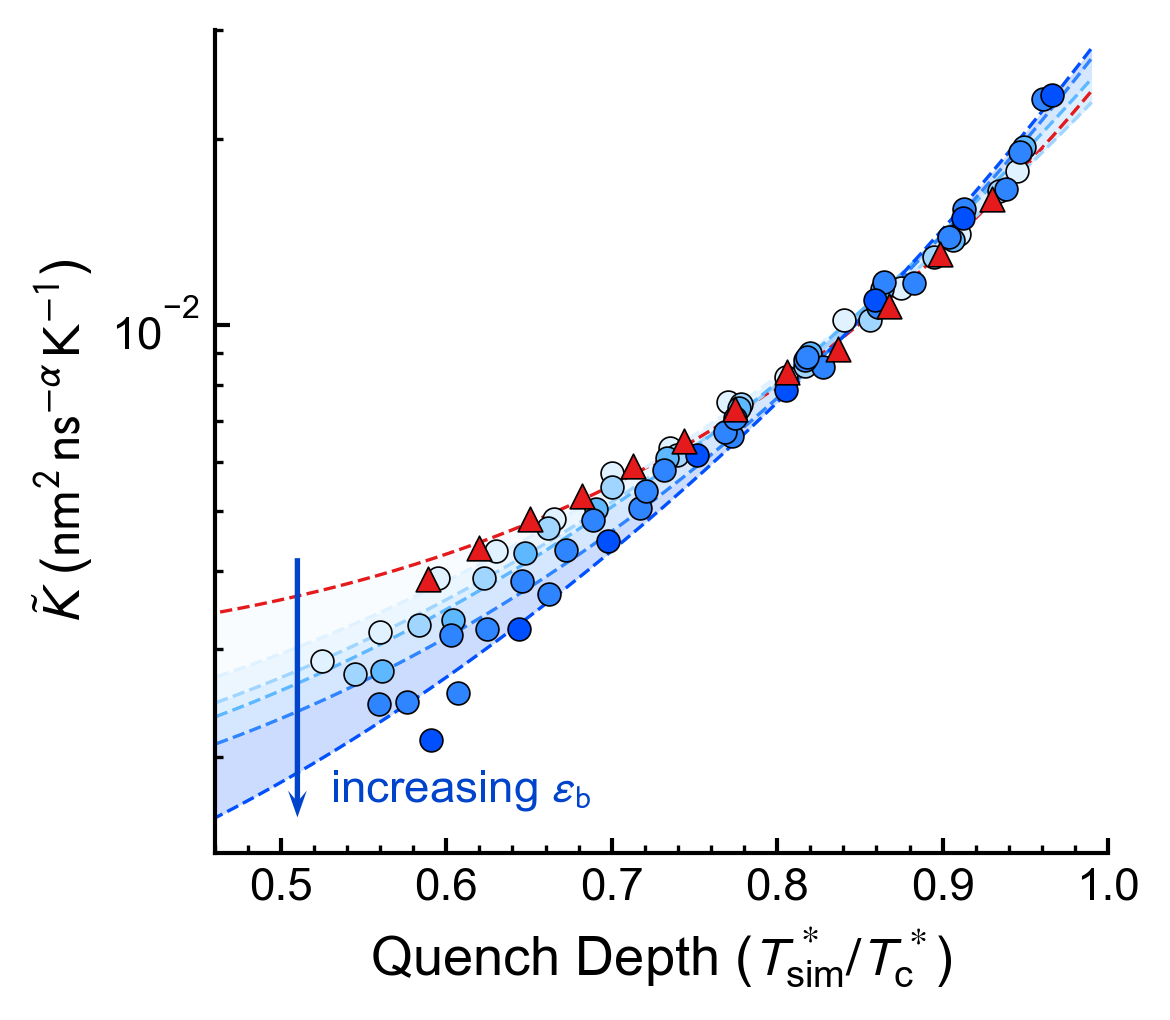

In [4]:
import os
import numpy as np
import mdtraj as md
import MDAnalysis as mda
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.markers import MarkerStyle
from scipy.optimize import leastsq

def calc_slab_properties(traj, nbins=500):
    scale = 10.0
    xyz = traj.xyz * scale
    L = traj.unitcell_lengths[0] * scale
    Lx, Ly, Lz = L[0], L[1], L[2]
    
    com_z = np.mean(xyz[:, :, 2], axis=1)
    shift = (Lz / 2.0) - com_z
    xyz[:, :, 2] = (xyz[:, :, 2] + shift[:, None]) % Lz
    
    z_all = xyz[:, :, 2].ravel()
    hist, edges = np.histogram(z_all, bins=nbins, range=(0, Lz))
    z = (edges[:-1] + edges[1:]) / 2
    rho = hist / (traj.n_frames * Lx * Ly * (Lz / nbins))
    
    rho_max = np.max(rho)
    rho_min = np.min(rho)
    if rho_max == 0 or (rho_max - rho_min) < 0.25 * rho_max:
        return None

    def slab_fit(z, rho_l, rho_v, z1, z2, w):
        return rho_v + 0.5 * (rho_l - rho_v) * (np.tanh((z - z1)/w) - np.tanh((z - z2)/w))
    
    p0 = [rho_max, rho_min, Lz*0.25, Lz*0.75, 1.0]
    try:
        popt, _ = curve_fit(slab_fit, z, rho, p0=p0, maxfev=5000)
        boundaries = sorted([popt[2], popt[3]])
    except:
        return None
        
    return boundaries

def calculate_dense_tamsd(dcd_file, gsd_file, chain_length=50, plot=False):
    traj = md.load(dcd_file, top=gsd_file)
    n_frames = traj.n_frames
    
    boundaries = calc_slab_properties(traj)
    if boundaries is None:
        return np.nan, np.nan
    z_min, z_max = boundaries

    n_chains = traj.n_atoms // chain_length
    scale = 10.0
    
    Lz = traj.unitcell_lengths[0, 2] * scale
    xyz = traj.xyz * scale 
    z_atoms = xyz[:, :, 2]
    z_chain_coms = z_atoms.reshape(n_frames, n_chains, chain_length).mean(axis=2)
    sys_com_z = np.mean(z_atoms, axis=1)
    shift = (Lz / 2.0) - sys_com_z
    z_filter = (z_chain_coms + shift[:, None]) % Lz 
    
    out_of_dense = ~((z_filter > z_min) & (z_filter < z_max))
    cum_out = np.cumsum(out_of_dense.astype(np.int32), axis=0)

    # PBC unwrap
    dz = z_chain_coms[1:] - z_chain_coms[:-1]
    dz = dz - Lz * np.round(dz / Lz)
    unwrapped_z = np.zeros_like(z_chain_coms)
    unwrapped_z[0] = z_chain_coms[0]
    unwrapped_z[1:] = z_chain_coms[0] + np.cumsum(dz, axis=0)
    slab_drift = np.mean(unwrapped_z, axis=1, keepdims=True)
    z_calc = unwrapped_z - slab_drift
    
    # calculate TAMSD
    max_lag = n_frames // 2
    lag_times = np.unique(np.logspace(0, np.log10(max_lag), num=50).astype(int))
    tamsd_values = []
    
    for lag in lag_times:
        mask_start = (z_filter[:-lag] > z_min) & (z_filter[:-lag] < z_max)
        
        continuous_check = (cum_out[lag:] - cum_out[:-lag]) == 0
        valid_mask = mask_start & continuous_check
        
        if np.any(valid_mask):
            diff = z_calc[lag:] - z_calc[:-lag]
            valid_sq_diff = diff[valid_mask] ** 2
            tamsd_values.append(np.mean(valid_sq_diff))
        else:
            tamsd_values.append(np.nan)
            
    tamsd_values = np.array(tamsd_values)
    time_ns = lag_times * 1.0

    valid_idx = ~np.isnan(tamsd_values)
    if np.sum(valid_idx) < 3:
        return np.nan, np.nan
    
    log_t = np.log(lag_times[valid_idx])
    log_msd = np.log(tamsd_values[valid_idx])
    
    slopes = np.diff(log_msd) / np.diff(log_t)
    cutoff_idx = len(log_t)
    
    for i, slope in enumerate(slopes):
        if i > 2 and (slope < 0.5 or slope > 1.2):
            cutoff_idx = i + 1
            break
            
    log_t_fit = log_t[:cutoff_idx]
    log_msd_fit = log_msd[:cutoff_idx]
    
    if len(log_t_fit) < 3:
        return np.nan, np.nan
    
    alpha, intercept = np.polyfit(log_t_fit, log_msd_fit, 1)
    K_fit = np.exp(intercept)

    if plot:
        plt.loglog(time_ns, tamsd_values, 'o', label='Simulation Data (Z-dir)', alpha=0.5)
        fit_time = np.exp(log_t_fit)
        plt.loglog(fit_time, K_fit*fit_time**alpha, 'r--', label=f'Fit: K={K_fit:.2f}, a={alpha:.2f}', linewidth=2)
        plt.xlabel('Lag Time (ns)', fontsize=12)
        plt.ylabel('TAMSD (nm$^2$)', fontsize=12)
    
    return K_fit, alpha

def calculate_phase_density(dcd_file, gsd_file, data_folder):
    u = mda.Universe(gsd_file, dcd_file)
    nlen = len(u.trajectory)
    natoms = u.atoms.n_atoms
    nres = 50
    nchains = int(natoms/nres)
    mass = u.atoms.masses
    box = u.dimensions
    lenx, leny, lenz = box[0], box[1], box[2]
    zmax, zmin = lenz / 2, - lenz / 2
    nbins = 500
    dz = lenz / nbins

    ## obtain the density data
    if os.path.exists(data_folder + str(T_sim) + '_dp.npy'):
        rhoave = np.load(data_folder + str(T_sim) + '_dp.npy')
    else:
        count = 0
        rhosum = np.zeros(nbins)
        for frame in np.arange(300, nlen, 2):
            if frame % 100 == 0:
                print(frame)
            ts = u.trajectory[frame]
            cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
            massz = np.zeros(nbins)
            for i in range(natoms):
                nposz = ts.positions[i][2] - cmassz
                nmass = mass[i]
                idx = int((nposz - zmin) / dz)
                if idx >= 500:
                    idx -= 500
                if idx < 0:
                    idx += 500
                massz[idx] += nmass
            rhoz = massz / (lenx * leny * dz * 6.02214e-1)
            rhosum += rhoz
            count += 1
        rhoave = rhosum / count
        rhoidx = np.where(rhoave > max(rhoave) * 0.2)
        mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
        if mc_idx > 0:
            tmp = rhoave[:mc_idx].copy()
            rhoave[:-mc_idx] = rhoave[mc_idx:]
            rhoave[-mc_idx:] = tmp
        if mc_idx < 0:
            tmp = rhoave[mc_idx:].copy()
            rhoave[-mc_idx:] = rhoave[:mc_idx]
            rhoave[:-mc_idx] = tmp
        
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        np.save(data_folder + str(T_sim) + '_dp.npy', rhoave)
    
    rho_max = max(rhoave)
    rho_min = min(rhoave)
    rho_hd, rho_ld = 0, 0
    count_hd, count_ld = 0, 0
    for rho in rhoave:
        if rho >= rho_max * 0.95:
            rho_hd += rho
            count_hd += 1
        if rho <= rho_min + 50:
            rho_ld += rho
            count_ld += 1
    rho_hd /= count_hd
    rho_ld /= count_ld

    return rho_hd, rho_ld

def err_Tc(param, T, delta_rho):
    Tc, A = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

diff_list, rho_list, temp_list, reduced_temp_list, alpha_list, eb_list, ew_list = [], [], [], [], [], [], []
folders = os.listdir('traj/poly50/')
folders.sort()
for folder in folders:
    if folder == 'hps' or folder == 'data' or folder == 'data0' or folder == 'data1':
        continue
    print(folder)
    rho_dense_tmp, rho_dilute_tmp, temp_tmp = [], [], []
    for T_sim in range(0, 1000, 10):
        traj_folder = 'traj/poly50/' + folder + '/' + str(T_sim) + '/'
        data_folder = 'data/poly50/' + folder + '/'
        param = folder.split('_')
        if len(param) == 1:
            continue
        if not os.path.exists(traj_folder):
            continue

        gsdfile = traj_folder + str(T_sim) + '.gsd'
        dcdfile = traj_folder + str(T_sim) + '.dcd'
        
        rho_dense, rho_dilute = calculate_phase_density(dcdfile, gsdfile, data_folder)
        if abs(rho_dense - rho_dilute) <= 50:
            continue

        ## obtain diffusion coefficient data
        K_fit, alpha_fit = calculate_dense_tamsd(dcdfile, gsdfile, chain_length=50, plot=False)

        if K_fit > 5:
            continue
        
        rho_dense_tmp.append(rho_dense)
        rho_dilute_tmp.append(rho_dilute)
        diff_list.append(K_fit / T_sim)
        temp_tmp.append(T_sim)
        alpha_list.append(alpha_fit)
        eb_list.append(float(param[2]))
        ew_list.append(float(param[3]))
    
    delta_rho = np.array(rho_dense_tmp) - np.array(rho_dilute_tmp)
    T_prods = np.array(temp_tmp)
    param = leastsq(err_Tc, [400, 100], args=(T_prods, delta_rho), full_output=True)
    Tc, factor = param[0]

    reduced_temp_list.extend(T_prods / Tc)
    rho_list.extend(rho_dense_tmp)
    temp_list.extend(temp_tmp)

diff_hps_list, rho_hps_list, rho_dilute_hps_list, temp_hps_list = [], [], [], []
folders = os.listdir('traj/poly50/hps/')
folders.sort()
for T_sim in range(0, 1000, 10):
    traj_folder = 'traj/poly50/hps/' + str(T_sim) + '/'
    data_folder = 'data/poly50/hps/'
    if not os.path.exists(traj_folder):
        continue

    gsdfile = traj_folder + str(T_sim) + '.gsd'
    dcdfile = traj_folder + str(T_sim) + '.dcd'
    
    rho_dense, rho_dilute = calculate_phase_density(dcdfile, gsdfile, data_folder)
    if abs(rho_dense - rho_dilute) <= 50:
        continue

    K_fit, alpha_fit = calculate_dense_tamsd(dcdfile, gsdfile, chain_length=50, plot=False)

    if K_fit > 5:
        continue
    
    rho_hps_list.append(rho_dense)
    diff_hps_list.append(K_fit / T_sim)
    temp_hps_list.append(T_sim)
    rho_dilute_hps_list.append(rho_dilute)

delta_rho = np.array(rho_hps_list) - np.array(rho_dilute_hps_list)
T_prods = np.array(temp_hps_list)
param = leastsq(err_Tc, [400, 100], args=(T_prods, delta_rho), full_output=True)
Tc, factor = param[0]
reduced_temp_hps_list = np.array(temp_hps_list) / Tc

# =============================================================================
# 1. Style Settings
# =============================================================================
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0 
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8

def apply_pub_style(ax, remove_spines=True):
    ax.minorticks_on()
    ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)

# =============================================================================
# 2. Data Preparation
# =============================================================================
# Assumes lists are defined in context
rho_arr = np.array(rho_list)
diff_arr = np.array(diff_list)
reduced_temp_arr = np.array(reduced_temp_list)
eb_arr = np.array(eb_list)
ew_arr = np.array(ew_list)

# Filter for ew
mask = (ew_arr == 0.02) | (ew_arr == 0.03) | (ew_arr == 0.01)
rho_arr = rho_arr[mask]
diff_arr = diff_arr[mask]
reduced_temp_arr = reduced_temp_arr[mask]
eb_arr = eb_arr[mask]

norm = Normalize(vmin=min(eb_arr), vmax=max(eb_arr))

rho_hps_arr = np.array(rho_hps_list)
diff_hps_arr = np.array(diff_hps_list)
reduced_temp_hps_arr = np.array(reduced_temp_hps_list)

# =============================================================================
# 3. Fitting Logic (Refactored)
# =============================================================================

def model_func(x, a, b, c):
    """
    Exponential growth model: y = a * exp(b * x**3) + c
    """
    return a * np.exp(b * x**3) + c

def get_fit_curve(x_data, y_data, x_common):
    """
    Returns the y values of the fitted curve evaluated at x_common.
    Returns None if fit fails or not enough data.
    """
    if len(x_data) < 3:
        return None

    # Sort data (good practice for fitting)
    sort_idx = np.argsort(x_data)
    x_data = x_data[sort_idx]
    y_data = y_data[sort_idx]

    try:
        p0 = [0.001, 2.0, min(y_data)]
        popt, _ = curve_fit(model_func, x_data, y_data, p0=p0, maxfev=10000)
        
        # Evaluate on the common x axis
        y_fit = model_func(x_common, *popt)
        return y_fit
    except RuntimeError:
        print("Fit failed for a group.")
        return None

# =============================================================================
# 4. Plotting
# =============================================================================

cmap_blue = LinearSegmentedColormap.from_list("bright_blue", ["#E0F2FF", "#5EB8FF", "#0050FF"], N=256)
color_hps = '#E41A1C'

fig, ax = plt.subplots(figsize=(4, 3.5), dpi=300)
apply_pub_style(ax, remove_spines=True)

# Define common X axis for all fills and lines
# This ensures the fill_between polygons are constructed correctly
x_common = np.linspace(0.4, 0.99, 200)

# --- 1. Calculate HPS Fit First (Baseline) ---
y_fit_hps = get_fit_curve(reduced_temp_hps_arr, diff_hps_arr, x_common)

# Plot HPS Scatter and Line
ax.scatter(reduced_temp_hps_arr, diff_hps_arr, s=35, c=color_hps, marker='^',
           edgecolors='k', linewidths=0.4, alpha=1, zorder=3, label='HPS')
if y_fit_hps is not None:
    ax.plot(x_common, y_fit_hps, linestyle='--', color=color_hps, linewidth=0.8, zorder=1)

# --- 2. Iterate Desolvation Groups (Fill & Plot) ---
unique_ebs = np.unique(np.round(eb_arr, 2)) # Ensures sorted order (min to max)

# Initialize "previous" curve as HPS for the first fill
y_fit_prev = y_fit_hps 

for eb_val in unique_ebs:
    # Filter data
    sub_mask = (np.abs(eb_arr - eb_val) < 0.001)
    x_sub = reduced_temp_arr[sub_mask]
    y_sub = diff_arr[sub_mask]
    
    if len(x_sub) == 0: continue
    
    current_color = cmap_blue(norm(eb_val))
    
    # Calculate fit for current eb
    y_fit_curr = get_fit_curve(x_sub, y_sub, x_common)
    
    # --- FILLING LOGIC ---
    # Fill between Previous Curve (or HPS) and Current Curve
    if y_fit_prev is not None and y_fit_curr is not None:
        ax.fill_between(x_common, y_fit_prev, y_fit_curr, 
                        color=current_color, alpha=0.2, linewidth=0, zorder=0)
    
    # Scatter points
    ax.scatter(x_sub, y_sub, s=30, color=current_color, 
               edgecolors='k', linewidths=0.4, alpha=1, zorder=2)
    
    # Plot Fit Line
    if y_fit_curr is not None:
        ax.plot(x_common, y_fit_curr, linestyle='--', color=current_color, linewidth=0.8, zorder=1)
        # Update "previous" to "current" for the next iteration
        y_fit_prev = y_fit_curr

# --- Labels & Limits ---
ax.set_xlabel(r'Quench Depth ($T_\mathregular{sim}^*/T_\mathregular{c}^*$)', fontsize=13)
ax.set_ylabel(r'$\tilde{K}$ ($\mathrm{nm}^2\,\mathrm{ns}^{-\alpha}\,\mathrm{K}^{-1}$)', fontsize=13)
ax.set_xlim(0.46, 1)
ax.set_ylim(0.0014, 0.03)
ax.set_yscale('log')

# add annotations
ax.quiver(0.51, 0.0042, 0, -0.0026, angles='xy', scale_units='xy', scale=1,
          color='#0044cc', width=0.006, headwidth=3.5, headlength=5.0, headaxislength=3.5, zorder=20)
# ax.text(0.48, 0.0047, r'increasing $\epsilon_{\mathrm{b}}$', color='#0044cc', fontsize=9)
ax.text(0.53, 0.0017, r'increasing $\epsilon_{\mathrm{b}}$', color='#0044cc', fontsize=11)

plt.tight_layout()
plt.savefig("../../figures/diffusion/new_plot/K2t.svg", format="svg", bbox_inches='tight')
plt.show()

Param  | Exponent n | R^2   
------------------------------
0.06   | 0.260      | 0.956 
0.08   | 0.260      | 0.976 
0.10   | 0.260      | 0.986 
0.12   | 0.260      | 0.970 
0.14   | 0.260      | 0.986 


/tmp/ipykernel_2124625/2845670121.py:360: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout() # Be careful with add_axes and tight_layout, but usually okay if ax is main


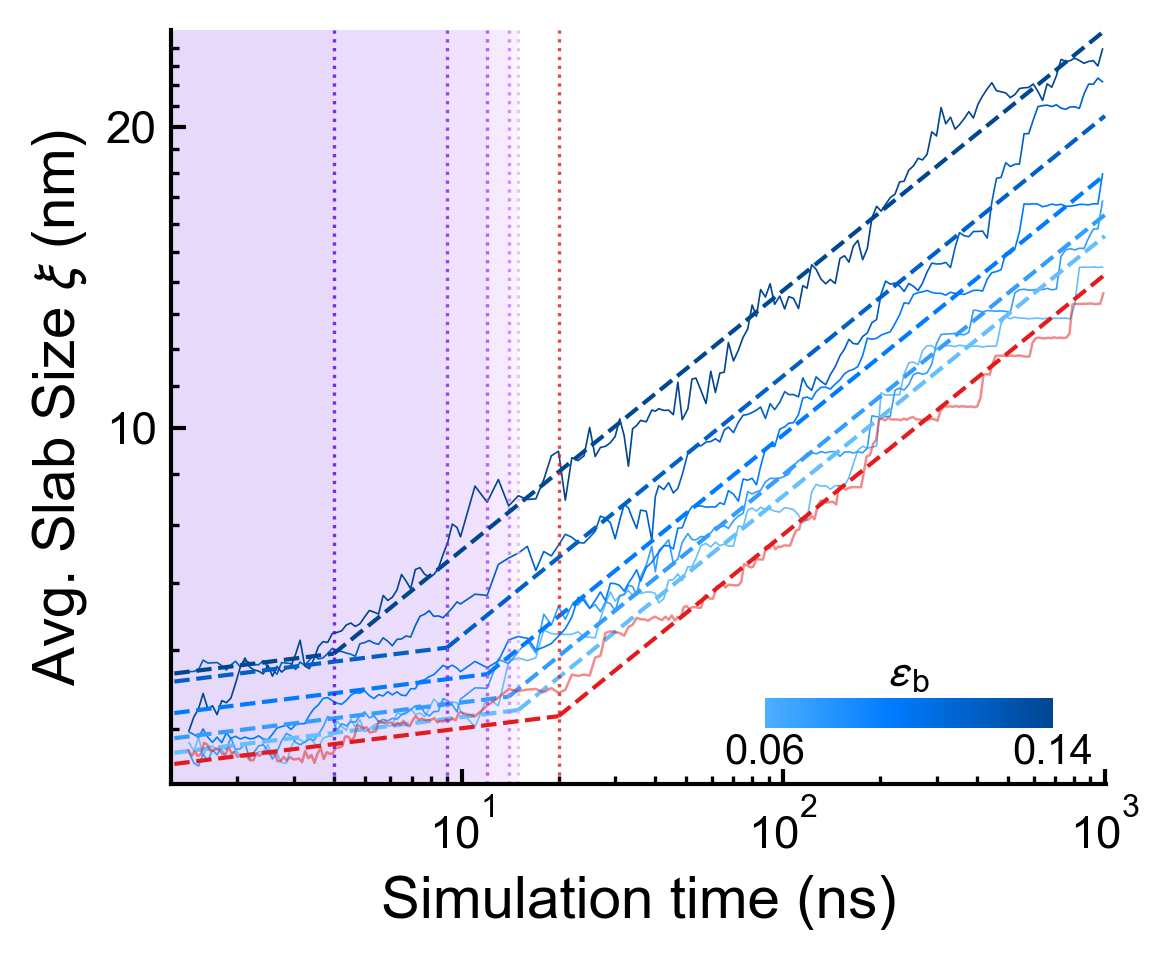

Param  | Exponent n | R^2   
------------------------------
0.00   | 0.260      | 0.932 
0.01   | 0.260      | 0.966 
0.02   | 0.260      | 0.969 
0.03   | 0.260      | 0.939 
0.04   | 0.260      | 0.978 


/tmp/ipykernel_2124625/2845670121.py:360: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout() # Be careful with add_axes and tight_layout, but usually okay if ax is main


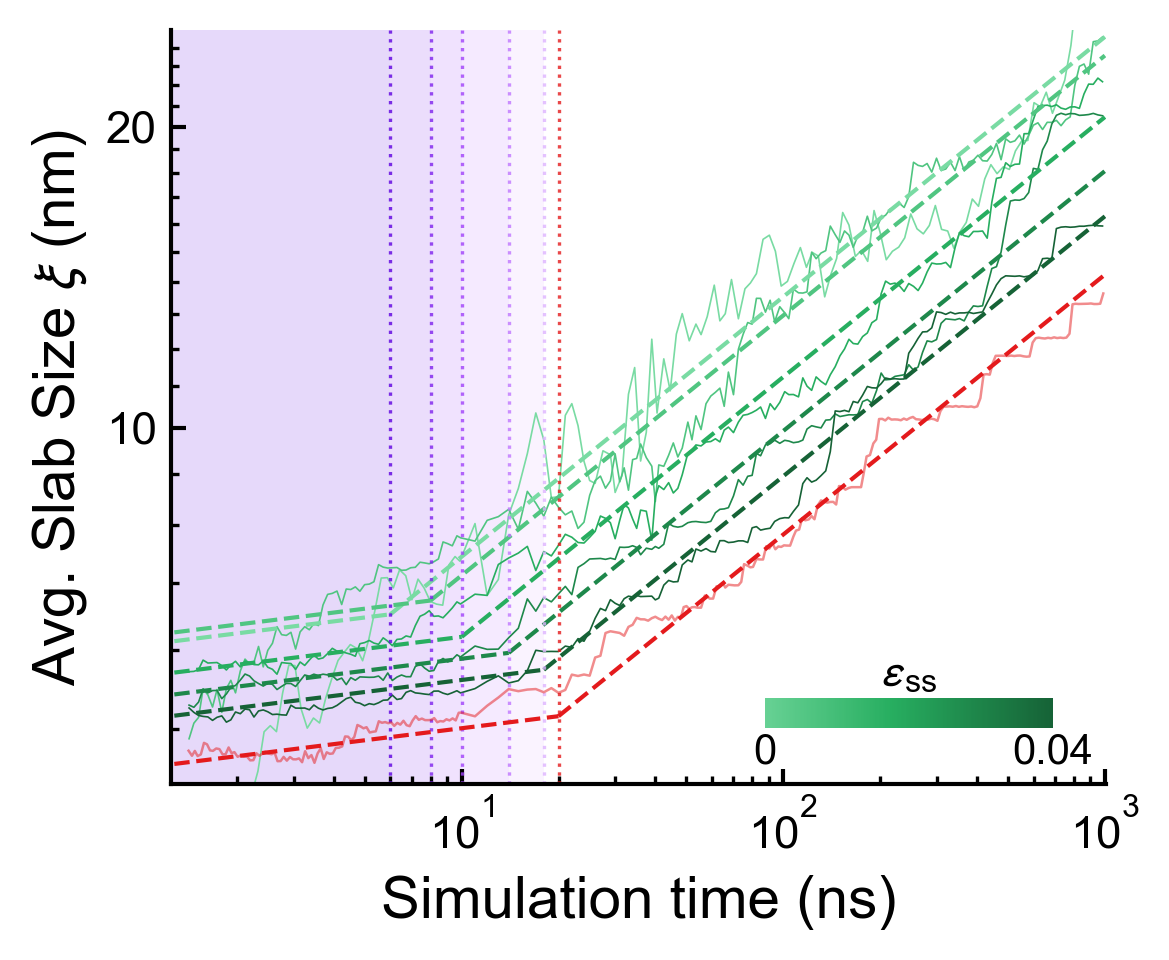

In [ ]:
import sys, os, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import MDAnalysis as mda
import matplotlib.ticker as ticker
from scipy.ndimage import label
from matplotlib.colors import LinearSegmentedColormap, Normalize

# =============================================================================
# 1. Style Settings (Matches Previous "Top-Tier" Style)
# =============================================================================
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0 
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8

def apply_pub_style(ax, remove_spines=True):
    ax.minorticks_on()
    ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
    
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)

# =============================================================================
# 2. Calculation Functions (Unchanged Logic)
# =============================================================================

def get_snapshot_data(folder, irep):
    data_dir = f'{folder}/rho_data_{irep}.npy'
    if os.path.exists(data_dir):
        return np.load(data_dir)
    
    # Fallback to calculation if npy doesn't exist (assuming MDAnalysis logic is correct)
    traj_dirs = [f'{folder}/fusion_{i}_{irep}' for i in ['initial', 'final']]
    universes = [mda.Universe(f'{td}.gsd', f'{td}.dcd', pbc=True) for td in traj_dirs]

    u_ref = universes[0]
    masses = u_ref.atoms.masses
    box = u_ref.dimensions
    lenx, leny, lenz = box[0], box[1], box[2]
    zmin = -lenz / 2
    nbins = 500
    dz = lenz / nbins
    norm_factor = 1.0 / (lenx * leny * dz * 6.02214e-1)
    total_frames = sum(len(u.trajectory) for u in universes)
    rho_all = np.zeros((total_frames, nbins))
    current_frame_idx = 0

    for u in universes:
        for ts in u.trajectory:
            z_positions = ts.positions[:, 2]
            indices = ((z_positions - zmin) / dz).astype(np.int64)
            indices = indices % nbins
            massz = np.bincount(indices, weights=masses, minlength=nbins)
            rho_all[current_frame_idx] = massz * norm_factor
            current_frame_idx += 1

    np.save(data_dir, rho_all)
    return rho_all

def calc_avg_slab_size(rhoz, Lz=180.0):
    dz = Lz / len(rhoz)
    threshold = np.mean(rhoz)
    mask = rhoz > threshold
    
    labeled, n_cores = label(mask)
    
    if n_cores == 0:
        return 0.0

    counts = np.bincount(labeled.ravel())[1:] 
    
    if labeled[0] != 0 and labeled[-1] != 0:
        first_label = labeled[0]
        last_label = labeled[-1]
        
        if first_label != last_label:
            counts[first_label - 1] += counts[last_label - 1]
            counts = np.delete(counts, last_label - 1)
            n_cores -= 1
            
    sizes_nm = counts * dz
    avg_size = np.mean(sizes_nm)
    return avg_size

def log_bin_smooth(time_array, data_array, n_bins=100):
    
    if len(time_array) == 0:
        return np.array([]), np.array([])
    
    t_min = max(time_array[0], 0.01)
    t_max = time_array[-1]
    bins = np.logspace(np.log10(t_min), np.log10(t_max), n_bins)
    
    bin_indices = np.digitize(time_array, bins)
    
    smooth_time = []
    smooth_data = []
    
    for i in range(1, len(bins)):
        mask = (bin_indices == i)
        if np.any(mask):
            smooth_time.append(np.mean(time_array[mask]))
            smooth_data.append(np.mean(data_array[mask]))
            
    return np.array(smooth_time), np.array(smooth_data)

def add_hps_data(ax):
    # HPS data logic (Modified to use log smoothing)
    try:
        size_list_all = []
        for irep in range(6):
            rhoz_all = get_snapshot_data(f'../rg/traj_fusion/poly50/hps', irep)
            time_list_rep, size_list_rep = [], []
            # 1ns - 10ns
            for frame in range(140, 1000):
                time_list_rep.append(frame * 0.01)
                size_list_rep.append(calc_avg_slab_size(rhoz_all[frame], 180))
            # > 10ns
            for frame in range(1000, rhoz_all.shape[0]):
                time_list_rep.append(10 + (frame - 1000))
                size_list_rep.append(calc_avg_slab_size(rhoz_all[frame], 180))
            size_list_all.append(size_list_rep)

        len_max = min([len(s) for s in size_list_all])
        time_raw = np.array(time_list_rep[:len_max])
        size_avg_raw = np.mean([s[:len_max] for s in size_list_all], axis=0)

        t_smooth, s_smooth = log_bin_smooth(time_raw, size_avg_raw, n_bins=300)

        t_start_val = 20
        fit_mask = t_smooth >= t_start_val
        t_fit = t_smooth[fit_mask]
        S_fit = s_smooth[fit_mask]
        if len(t_fit) > 2:
            log_t = np.log(t_fit)
            log_S = np.log(S_fit)
            
            slope_n = 0.26 
            intercept = np.mean(log_S - slope_n * log_t)
            
            fit_values = slope_n * log_t + intercept
            ss_res = np.sum((log_S - fit_values) ** 2)
            ss_tot = np.sum((log_S - np.mean(log_S)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            
            t_plot_late = np.logspace(np.log10(t_start_val), np.log10(1000), 50)
            y_plot_late = np.exp(intercept) * (t_plot_late ** slope_n)
            ax.plot(t_plot_late, y_plot_late, linestyle='--', linewidth=1.0, color='#E41A1C', alpha=1, zorder=2)
            S_join = np.exp(intercept) * (t_start_val ** slope_n)
            slope_early = 0.04
            A_early = S_join / (t_start_val ** slope_early)
            t_plot_early = np.logspace(np.log10(0.1), np.log10(t_start_val), 50)
            y_plot_early = A_early * (t_plot_early ** slope_early)
            ax.plot(t_plot_early, y_plot_early, linestyle='--', linewidth=1.0, color='#E41A1C', alpha=1, zorder=2)

        ax.plot(t_smooth, s_smooth, lw=0.6, alpha=0.5, color='#E41A1C', label='HPS')
        ax.axvline(x=t_start_val, color='#E41A1C', linestyle=':', linewidth=0.8, alpha=0.8)
    except Exception as e:
        print(f"Skipping HPS data: {e}")

# =============================================================================
# 3. Main Plotting Function
# =============================================================================

def plot_size_evolution_late_stage(param_list, fit_start_time, param_label, nrep=6):
    
    # Color definition
    if param_label == 'eb':
        cmap_data = LinearSegmentedColormap.from_list("vibrant_blue", ["#6EC6FF", "#007BFF", "#004085"], N=256)
        clist = cmap_data(np.linspace(0.05, 0.95, len(param_list)))
    elif param_label == 'ew':
        cmap_data = LinearSegmentedColormap.from_list("vibrant_green", ["#82E0AA", "#27AE60", "#145A32"], N=256)
        clist = cmap_data(np.linspace(0.05, 0.95, len(param_list)))
    else:
        raise ValueError("param_label must be 'eb' or 'ew'")
    
    cmap_purple = LinearSegmentedColormap.from_list("bright_purple", ["#F3E0FF", "#AC4DFF", "#5D00E0"], N=256)
    cmap_gray = LinearSegmentedColormap.from_list("bright_gray", ["#333333", "#727272", "#C9C9C9"], N=256)
    # clist_purple = cmap_purple(np.linspace(0.15, 0.85, len(param_list)))
    
    fig, ax = plt.subplots(figsize=(4, 3.3), dpi=300)
    
    # Apply Style (Remove spines, set ticks)
    apply_pub_style(ax, remove_spines=True)
    ax.set_facecolor('none')
    
    Lz = 180.0 # nm
    
    print(f"{'Param':<6} | {'Exponent n':<10} | {'R^2':<6}")
    print("-" * 30)

    sorted_indices = np.argsort(fit_start_time)
    rank_map = {original_idx: rank for rank, original_idx in enumerate(sorted_indices)}
    purple_colors_geometric = cmap_purple(np.linspace(1.0, 0.15, len(param_list)))
    gray_colors_geometric = cmap_gray(np.linspace(1.0, 0.15, len(param_list)))

    for i_param, param in enumerate(param_list):
        if param_label == 'eb':
            param_dir = 'des_0.20_{:.2f}_0.02'.format(param)
        elif param_label == 'ew':
            param_dir = 'des_0.20_0.12_{:.2f}'.format(param)
            
        size_list_all = []
        try:
            for irep in range(nrep):
                # Ensure path is correct for your environment
                rhoz_all = get_snapshot_data(f'../rg/traj_fusion/poly50/{param_dir}', irep)
                time_list_rep, size_list_rep = [], []
                
                start_frame = 140
                for frame in range(start_frame, 1000):
                    rhoz = rhoz_all[frame]
                    time_list_rep.append(frame * 0.01)
                    size_list_rep.append(calc_avg_slab_size(rhoz, Lz))
                for frame in range(1000, rhoz_all.shape[0]):
                    rhoz = rhoz_all[frame]
                    time_list_rep.append(10 + (frame - 1000))
                    size_list_rep.append(calc_avg_slab_size(rhoz, Lz))
                size_list_all.append(size_list_rep)
            size_list_all = np.array(size_list_all)
            if param == 0.06:
                replicate_means = np.mean(size_list_all, axis=1)
                indices_to_remove = np.argsort(replicate_means)[-2:]
                size_list_all = np.delete(size_list_all, indices_to_remove, axis=0)
            if param == 0.08:
                replicate_means = np.mean(size_list_all, axis=1)
                indices_to_remove = np.argsort(replicate_means)[:1]
                size_list_all = np.delete(size_list_all, indices_to_remove, axis=0)
        except Exception as e:
            print(f"Missing data for param {param}: {e}")
            continue
        
        len_max = min([len(s) for s in size_list_all])
        time_raw = np.array(time_list_rep[:len_max])
        size_all_matrix = np.array([s[:len_max] for s in size_list_all])
        size_avg_raw = np.mean(size_all_matrix, axis=0)

        # Smooth
        if param == 0.00:
            time_smooth, size_smooth = log_bin_smooth(time_raw, size_avg_raw, n_bins=150)
        else:
            time_smooth, size_smooth = log_bin_smooth(time_raw, size_avg_raw, n_bins=200)

        # Fitting Logic
        color = clist[i_param]
        t_start_val = fit_start_time[i_param]
        
        fit_mask = time_smooth >= t_start_val
        t_fit = time_smooth[fit_mask]
        S_fit = size_smooth[fit_mask]

        if len(t_fit) > 2:
            log_t = np.log(t_fit)
            log_S = np.log(S_fit)
            
            slope_n = 0.26 
            intercept = np.mean(log_S - slope_n * log_t)
            
            fit_values = slope_n * log_t + intercept
            ss_res = np.sum((log_S - fit_values) ** 2)
            ss_tot = np.sum((log_S - np.mean(log_S)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            
            print(f"{param:<6.2f} | {slope_n:<10.3f} | {r2:<6.3f}")
            
            fit_linewidth = 1.0
            color_fit = clist[i_param]
            t_plot_late = np.logspace(np.log10(t_start_val), np.log10(1000), 50)
            y_plot_late = np.exp(intercept) * (t_plot_late ** slope_n)
            ax.plot(t_plot_late, y_plot_late, linestyle='--', linewidth=fit_linewidth, color=color_fit, alpha=1, zorder=2)
            S_join = np.exp(intercept) * (t_start_val ** slope_n)
            slope_early = 0.04
            A_early = S_join / (t_start_val ** slope_early)
            t_plot_early = np.logspace(np.log10(0.1), np.log10(t_start_val), 50)
            y_plot_early = A_early * (t_plot_early ** slope_early)
            ax.plot(t_plot_early, y_plot_early, linestyle='--', linewidth=fit_linewidth, color=color_fit, alpha=1, zorder=2)
        
        # Plot Data: lw=0.6
        ax.plot(time_smooth, size_smooth, lw=0.4, alpha=1.0, color=color, zorder=1)

        # --- Start Time Line & Shading ---
        current_rank = rank_map[i_param]
        current_purple = purple_colors_geometric[current_rank]
        ax.axvline(x=fit_start_time[i_param], color=current_purple, linestyle=':', linewidth=0.8, alpha=0.8)
        sorted_times = np.sort(fit_start_time) 
        shade_alpha = 0.15
        if current_rank == 0:
            ax.axvspan(0.1, fit_start_time[i_param], 
                       color=current_purple, alpha=shade_alpha, zorder=0, lw=0)
        else:
            prev_time = sorted_times[current_rank - 1]
            ax.axvspan(prev_time, fit_start_time[i_param], 
                       color=current_purple, alpha=shade_alpha, zorder=0, lw=0)
    
    add_hps_data(ax)
    
    # Labels
    ax.set_xlabel('Simulation time (ns)', fontsize=14)
    ax.set_ylabel(r'Avg. Slab Size $\xi$ (nm)', fontsize=14)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    if param_label == 'eb':
        ax.set_xlim(1.25, 1010)
        ax.set_ylim(4.4, 25)
    elif param_label == 'ew':
        ax.set_xlim(1.25, 1010)
        ax.set_ylim(4.4, 25)
    
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    custom_ticks = [10, 20]
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels([str(i) for i in custom_ticks])

    # Colorbar positioning (Manual Axis)
    # Using 'none' facecolor for consistency
    cbar_ax = fig.add_axes([0.65, 0.25, 0.24, 0.03]) 
    cmap_partial = mpl.colors.ListedColormap(cmap_data(np.linspace(0.15, 0.95, 256)))
    sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=Normalize(vmin=0, vmax=1))
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    
    minor_ticks = [4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24]
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    # Colorbar Style
    cbar.outline.set_linewidth(0) # Remove outline
    cbar.set_ticks([])
    
    # Text
    if param_label == 'eb':
        cbar_ax.text(0.5, 1.4, r'$\epsilon_\mathregular{b}$', transform=cbar_ax.transAxes, fontsize=11, ha='center')
        cbar_ax.text(0.0, -1.2, '0.06', transform=cbar_ax.transAxes, fontsize=10, ha='center')
        cbar_ax.text(1.0, -1.2, '0.14', transform=cbar_ax.transAxes, fontsize=10, ha='center')
    elif param_label == 'ew':
        cbar_ax.text(0.5, 1.4, r'$\epsilon_\mathregular{ss}$', transform=cbar_ax.transAxes, fontsize=11, ha='center')
        cbar_ax.text(0.0, -1.2, '0', transform=cbar_ax.transAxes, fontsize=10, ha='center')
        cbar_ax.text(1.0, -1.2, '0.04', transform=cbar_ax.transAxes, fontsize=10, ha='center')
    plt.tight_layout()
    plt.show()

# Execution
# Note: Ensure the file paths in get_snapshot_data match your actual directory structure
plot_size_evolution_late_stage([0.06, 0.08, 0.10, 0.12, 0.14], [15, 14, 12, 9, 4], 'eb')
plot_size_evolution_late_stage([0.00, 0.01, 0.02, 0.03, 0.04], [6, 8, 10, 14, 18], 'ew')

/tmp/ipykernel_2124625/3479202520.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95]) # Reserve space for colorbar


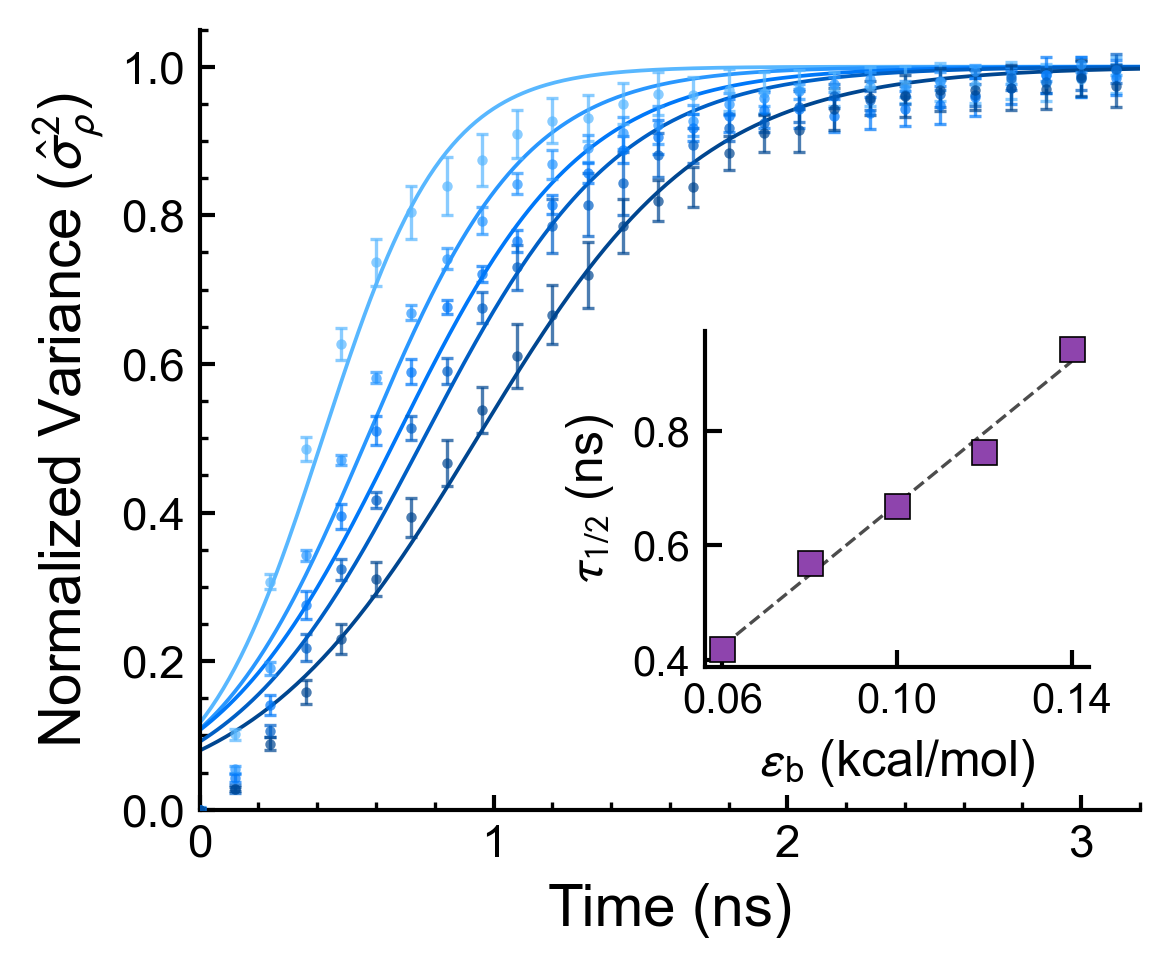

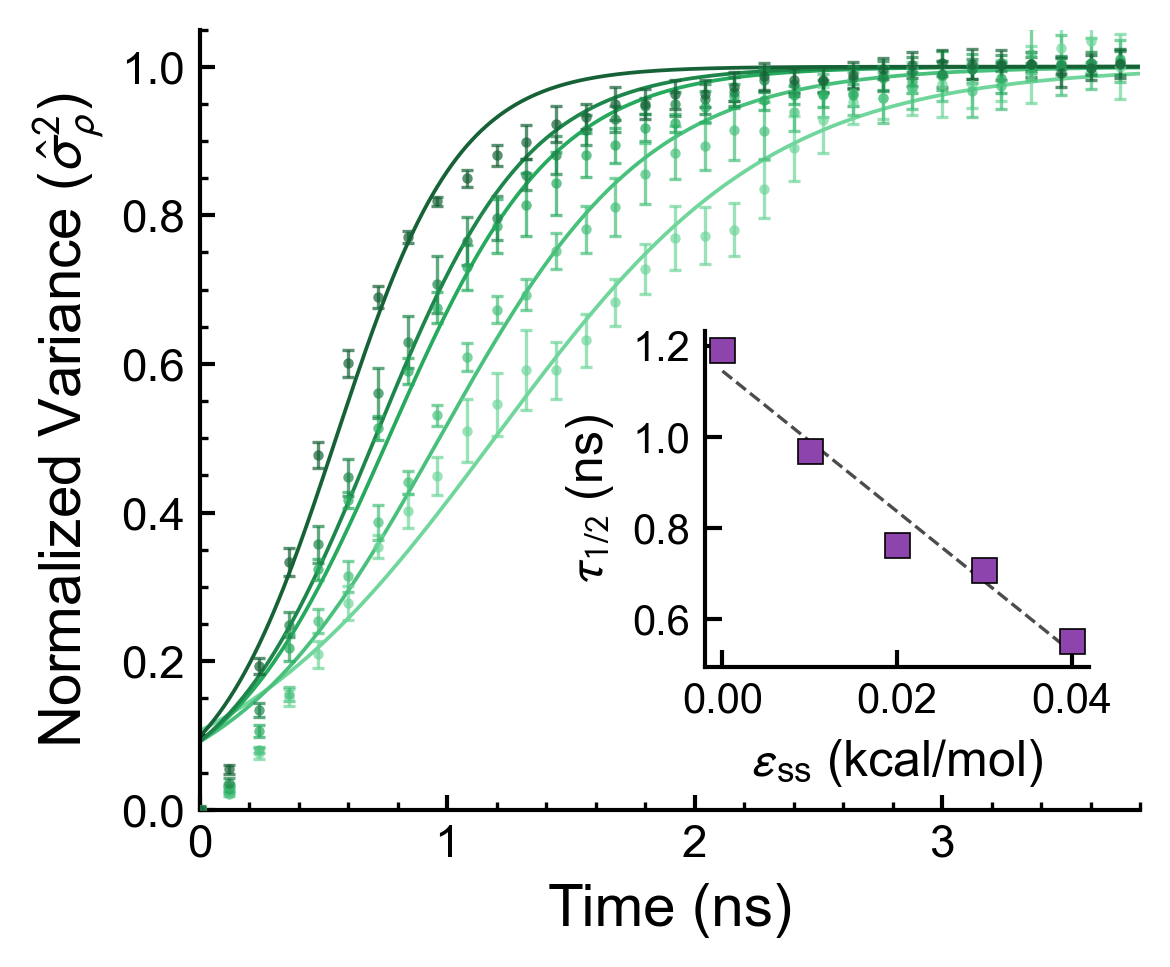

In [ ]:
import sys
import os
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.optimize import curve_fit

# =============================================================================
# 1. Style & Helper Functions
# =============================================================================

def apply_pub_style(ax, remove_spines=True):
    ax.minorticks_on()
    ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)

def sigmoid_func(t, tau, rate):
    return 1 / (1 + np.exp(-rate * (t - tau)))

# =============================================================================
# 2. Calculation Logic
# =============================================================================

def calculate_averaged_variance_data(param, n_replicas=6):
    
    nbins = 500
    n_frames_1ns = 401 
    
    all_variances = []
    time_points = None
    
    for rep_id in range(n_replicas):
        if param == 'des_0.20_0.12_0.02':
            file_base = f'../rg/traj_fusion/poly50/{param}_initial/fusion_initial_{rep_id}'
        else:
            file_base = f'../rg/traj_fusion/poly50/{param}/fusion_initial_{rep_id}'
        gsd_file = file_base + '.gsd'
        dcd_file = file_base + '.dcd'
        
        if not os.path.exists(dcd_file):
            continue
        try:
            u = mda.Universe(gsd_file, dcd_file, pbc=True)
        except:
            continue
            
        masses = u.atoms.masses
        box = u.dimensions
        lenz = box[2]
        zmin, zmax = -lenz/2, lenz/2
        dz = lenz / nbins
        density_factor = 1.0 / (box[0] * box[1] * dz * 6.02214e-1)
        
        limit_frames = min(n_frames_1ns, len(u.trajectory))
        if time_points is None:
            time_points = np.arange(limit_frames) * 0.01
            
        current_rep_variances = []
        for frame_idx in range(limit_frames):
            ts = u.trajectory[frame_idx]
            pos_z = ts.positions[:, 2]
            # Wrap
            pos_z = np.where(pos_z < zmin, pos_z + lenz, pos_z)
            pos_z = np.where(pos_z >= zmax, pos_z - lenz, pos_z)
            
            hist_mass, _ = np.histogram(pos_z, bins=nbins, range=(zmin, zmax), weights=masses)
            rhoz = hist_mass * density_factor
            current_rep_variances.append(np.var(rhoz))
        
        all_variances.append(current_rep_variances)

    all_variances = np.array(all_variances)
    if all_variances.shape[0] == 0:
        return None, None, None

    mean_var = np.mean(all_variances, axis=0)
    sem_var = np.std(all_variances, axis=0) / np.sqrt(all_variances.shape[0])
    
    # Normalize (using last 30% plateau)
    plateau = np.mean(mean_var[int(len(mean_var)*0.7):])
    min_val = mean_var[0]
    
    # Avoid div by zero
    if plateau - min_val == 0:
        norm_mean = mean_var
        norm_sem = sem_var
    else:
        norm_mean = (mean_var - min_val) / (plateau - min_val)
        norm_sem = sem_var / (plateau - min_val)
        
    return time_points, norm_mean, norm_sem

# =============================================================================
# 3. Plotting Function
# =============================================================================

def plot_variance_evolution_smooth(param_label):
    
    # 1. Setup Colors & Params
    if param_label == 'eb':
        params = ['des_0.20_0.06_0.02', 'des_0.20_0.08_0.02', 'des_0.20_0.10_0.02', 'des_0.20_0.12_0.02', 'des_0.20_0.14_0.02']
        x_vals = [0.06, 0.08, 0.10, 0.12, 0.14]
        xlabel_inset = r'$\epsilon_\mathregular{b}$ (kcal/mol)'
        # Using the "Academic Blue" from previous context
        cmap_list = ["#6EC6FF", "#007BFF", "#004085"]
        cmap_obj = LinearSegmentedColormap.from_list("academic_blue", cmap_list, N=256)
        
    elif param_label == 'ew':
        params = ['des_0.20_0.12_0.00', 'des_0.20_0.12_0.01', 'des_0.20_0.12_0.02', 'des_0.20_0.12_0.03', 'des_0.20_0.12_0.04']
        x_vals = [0.00, 0.01, 0.02, 0.03, 0.04]
        xlabel_inset = r'$\epsilon_\mathregular{ss}$ (kcal/mol)'
        # Using "Academic Green"
        cmap_list = ["#82E0AA", "#27AE60", "#145A32"]
        cmap_obj = LinearSegmentedColormap.from_list("academic_green", cmap_list, N=256)

    colors = cmap_obj(np.linspace(0.1, 0.95, len(params)))
    
    # 2. Create Figure
    fig, ax = plt.subplots(figsize=(4, 3.5), dpi=300)
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'
    apply_pub_style(ax)
    
    tau_list = []
    tau_err_list = []
    
    # 3. Loop & Plot
    for i, p_str in enumerate(params):
        t, y, y_err = calculate_averaged_variance_data(p_str)
        if t is None: continue
            
        color = colors[i]
        
        # --- A. Fit Smooth Curve (Sigmoid) ---
        # Initial guess: tau=1.0, rate=5.0
        try:
            popt, pcov = curve_fit(sigmoid_func, t, y, p0=[1.0, 5.0], maxfev=5000)
            y_fit = sigmoid_func(t, *popt)
            
            # Extract tau (half-time) directly from fit parameter
            tau_half = popt[0]
            perr = np.sqrt(np.diag(pcov))
            tau_err = perr[0]
            
        except RuntimeError:
            # Fallback if fit fails: simple interpolation
            y_fit = y
            # Calc tau manually
            idx = np.abs(y - 0.5).argmin()
            tau_half = t[idx]
            tau_err = 0.05 # arbitrary small error
        
        tau_list.append(tau_half)
        tau_err_list.append(tau_err)
        
        ax.plot(t, y_fit, color=color, linewidth=0.9, zorder=2)
        
        sub = 12
        ax.errorbar(t[::sub], y[::sub], yerr=y_err[::sub], fmt='o', markersize=2.5, markerfacecolor=color, markeredgecolor='none', ecolor=color, elinewidth=0.8, capsize=1.5, capthick=0.8, zorder=3, alpha=0.7)
    
    # 4. Main Axes Styling
    ax.set_xlabel('Time (ns)', fontsize=14)
    ax.set_ylabel(r"Normalized Variance ($\hat{\sigma}^2_{\rho}$)", fontsize=14)
    if param_label == 'eb':
        ax.set_xlim(0, 3.2)
    else:
        ax.set_xlim(0, 3.8)
    ax.set_ylim(0, 1.05)
    
    # 5. Inset Plot (Tau vs Epsilon)
    # Position: [left, bottom, width, height]
    ax_inset = fig.add_axes([0.6, 0.3, 0.32, 0.32])
    
    # Fit linear trend for inset
    z = np.polyfit(x_vals, tau_list, 1)
    p_poly = np.poly1d(z)
    
    # Purple color for inset data
    purple = '#8E44AD' 
    ax_inset.errorbar(x_vals, tau_list, yerr=tau_err_list, fmt='s', 
                      markerfacecolor=purple, markeredgecolor='k', markersize=6, markeredgewidth=0.4,
                      ecolor=purple, elinewidth=0.8, capsize=2, zorder=10)
    ax_inset.plot(x_vals, p_poly(x_vals), 'k--', lw=0.8, alpha=0.7)
    
    ax_inset.set_xlabel(xlabel_inset, fontsize=12)
    ax_inset.set_ylabel(r'$\tau_{1/2}$ (ns)', fontsize=12)
    
    # Adjust inset ticks
    if param_label == 'eb':
        ax_inset.set_xticks([0.06, 0.10, 0.14])
    else:
        ax_inset.set_xticks([0.00, 0.02, 0.04])
        
    ax_inset.tick_params(labelsize=10, direction='in', length=4, width=1)
    # Inset style: hide top/right spines
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.patch.set_alpha(0) # Transparent background

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Reserve space for colorbar
    plt.show()

# Execution
plot_variance_evolution_smooth('eb')
plot_variance_evolution_smooth('ew')

Plotting Top Panel (Variance)...


/home/swalker/.conda/envs/cg2all/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Plotting Bottom Panel (Size)...
Drawing Timeline Bar...


/tmp/ipykernel_2124625/951777458.py:479: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_bar.axvspan(0.6, t_fluc_end, color='#D0D0D0', alpha=0.8, edgecolor='none', clip_on=False)
/tmp/ipykernel_2124625/951777458.py:481: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_bar.axvspan(t_fluc_end, t_coarse_start, color='#E0C0FF', alpha=0.8, edgecolor='none', clip_on=False)
/tmp/ipykernel_2124625/951777458.py:483: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_bar.axvspan(t_coarse_start, 1000, color='#FFE0C0', alpha=0.8, edgecolor='none', clip_on=False)
/tmp/ipykernel_2124625/951777458.py:526: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


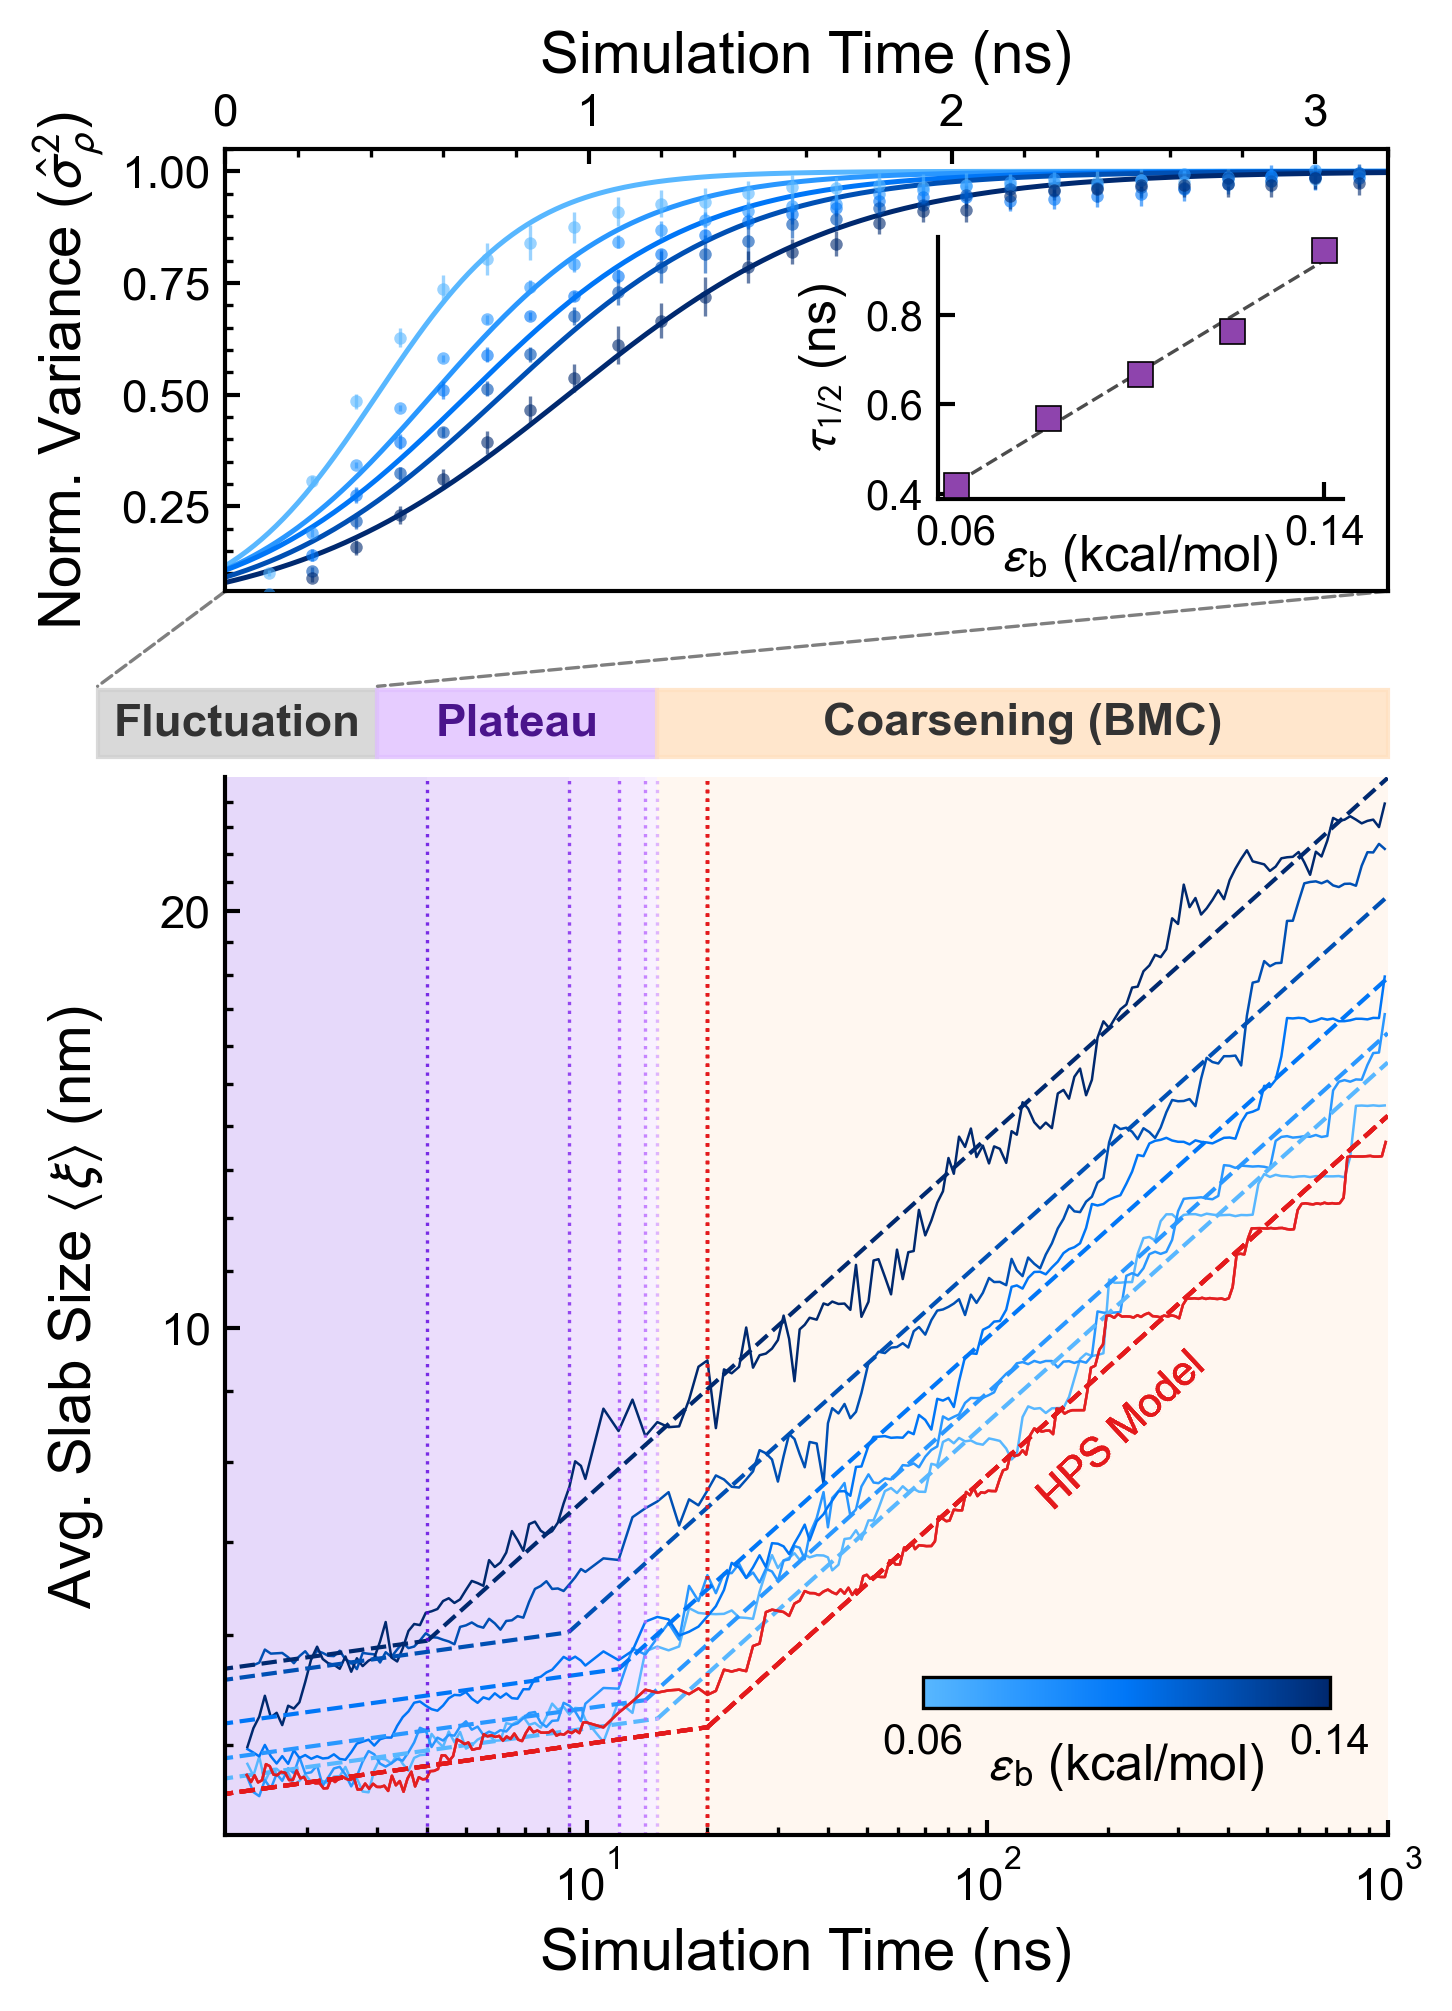

Plotting Top Panel (Variance)...


/home/swalker/.conda/envs/cg2all/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Plotting Bottom Panel (Size)...
Drawing Timeline Bar...


/tmp/ipykernel_2124625/951777458.py:479: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_bar.axvspan(0.6, t_fluc_end, color='#D0D0D0', alpha=0.8, edgecolor='none', clip_on=False)
/tmp/ipykernel_2124625/951777458.py:481: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_bar.axvspan(t_fluc_end, t_coarse_start, color='#E0C0FF', alpha=0.8, edgecolor='none', clip_on=False)
/tmp/ipykernel_2124625/951777458.py:483: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax_bar.axvspan(t_coarse_start, 1000, color='#FFE0C0', alpha=0.8, edgecolor='none', clip_on=False)
/tmp/ipykernel_2124625/951777458.py:526: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


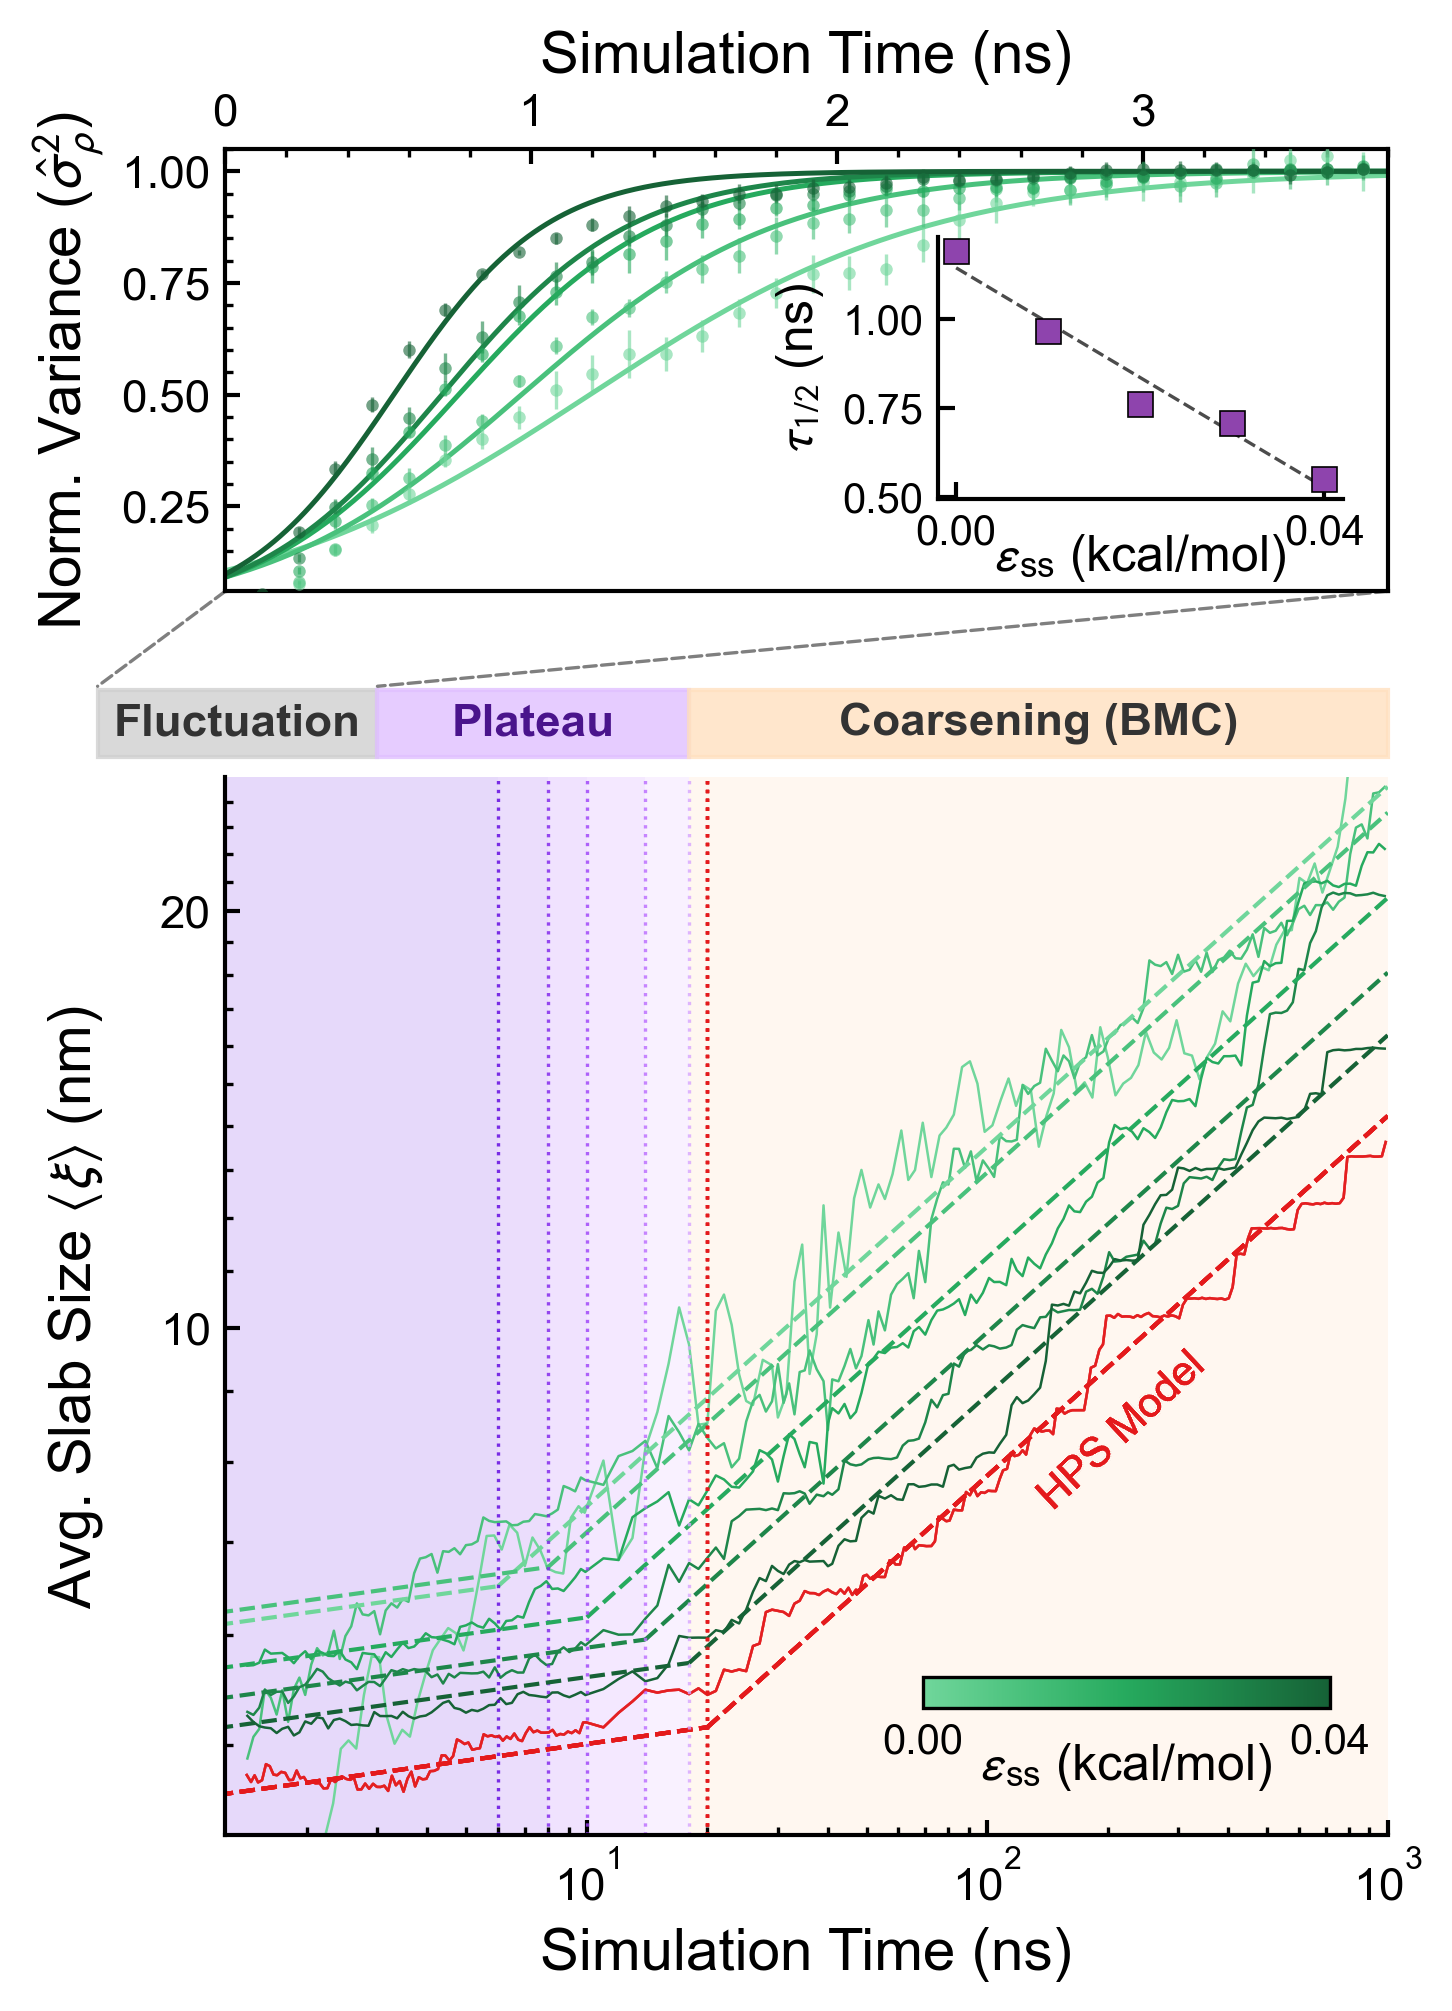

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import ConnectionPatch
from scipy.optimize import curve_fit
import MDAnalysis as mda
from scipy.ndimage import label

# =============================================================================
# 1. General Settings
# =============================================================================
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0

def apply_pub_style(ax, remove_spines=True):
    ax.minorticks_on()
    ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

def get_colors(param_label, n_points):
    if param_label == 'eb':
        # Academic Blue
        cmap = LinearSegmentedColormap.from_list("vibrant_blue", ["#6EC6FF", "#007BFF", "#002060"], N=256)
    elif param_label == 'ew':
        # Academic Green
        cmap = LinearSegmentedColormap.from_list("vibrant_green", ["#82E0AA", "#27AE60", "#145A32"], N=256)
    return cmap(np.linspace(0.1, 0.95, n_points))

# =============================================================================
# 2. Data Calculation Functions (Integrated Version)
# =============================================================================

# --- A. Density Fluctuation Part ---
def calculate_averaged_variance_data(param, n_replicas=6):
    """
    Returns raw time, mean_variance, and sem_variance arrays.
    Does NOT handle plotting.
    """
    nbins = 500
    n_frames_1ns = 401 
    
    all_variances = []
    time_points = None
    
    for rep_id in range(n_replicas):
        if param == 'des_0.20_0.12_0.02':
            file_base = f'../rg/traj_fusion/poly50/{param}_initial/fusion_initial_{rep_id}'
        else:
            file_base = f'../rg/traj_fusion/poly50/{param}/fusion_initial_{rep_id}'
        gsd_file = file_base + '.gsd'
        dcd_file = file_base + '.dcd'
        
        if not os.path.exists(dcd_file):
            continue
        try:
            u = mda.Universe(gsd_file, dcd_file, pbc=True)
        except:
            continue
            
        masses = u.atoms.masses
        box = u.dimensions
        lenz = box[2]
        zmin, zmax = -lenz/2, lenz/2
        dz = lenz / nbins
        density_factor = 1.0 / (box[0] * box[1] * dz * 6.02214e-1)
        
        limit_frames = min(n_frames_1ns, len(u.trajectory))
        if time_points is None:
            time_points = np.arange(limit_frames) * 0.01
            
        current_rep_variances = []
        for frame_idx in range(limit_frames):
            ts = u.trajectory[frame_idx]
            pos_z = ts.positions[:, 2]
            # Wrap
            pos_z = np.where(pos_z < zmin, pos_z + lenz, pos_z)
            pos_z = np.where(pos_z >= zmax, pos_z - lenz, pos_z)
            
            hist_mass, _ = np.histogram(pos_z, bins=nbins, range=(zmin, zmax), weights=masses)
            rhoz = hist_mass * density_factor
            current_rep_variances.append(np.var(rhoz))
        
        all_variances.append(current_rep_variances)

    all_variances = np.array(all_variances)
    if all_variances.shape[0] == 0:
        return None, None, None

    mean_var = np.mean(all_variances, axis=0)
    sem_var = np.std(all_variances, axis=0) / np.sqrt(all_variances.shape[0])
    
    # Normalize (using last 30% plateau)
    plateau = np.mean(mean_var[int(len(mean_var)*0.7):])
    min_val = mean_var[0]
    
    # Avoid div by zero
    if plateau - min_val == 0:
        norm_mean = mean_var
        norm_sem = sem_var
    else:
        norm_mean = (mean_var - min_val) / (plateau - min_val)
        norm_sem = sem_var / (plateau - min_val)
        
    return time_points, norm_mean, norm_sem

def calc_avg_slab_size(rhoz, Lz=180.0):
    dz = Lz / len(rhoz)
    threshold = np.mean(rhoz)
    mask = rhoz > threshold
    
    labeled, n_cores = label(mask)
    
    if n_cores == 0:
        return 0.0

    counts = np.bincount(labeled.ravel())[1:] 
    
    if labeled[0] != 0 and labeled[-1] != 0:
        first_label = labeled[0]
        last_label = labeled[-1]
        
        if first_label != last_label:
            counts[first_label - 1] += counts[last_label - 1]
            counts = np.delete(counts, last_label - 1)
            n_cores -= 1
            
    sizes_nm = counts * dz
    avg_size = np.mean(sizes_nm)
    return avg_size

def log_bin_smooth(time_array, data_array, n_bins=100):
    
    if len(time_array) == 0:
        return np.array([]), np.array([])
    
    t_min = max(time_array[0], 0.01)
    t_max = time_array[-1]
    bins = np.logspace(np.log10(t_min), np.log10(t_max), n_bins)
    
    bin_indices = np.digitize(time_array, bins)
    
    smooth_time = []
    smooth_data = []
    
    for i in range(1, len(bins)):
        mask = (bin_indices == i)
        if np.any(mask):
            smooth_time.append(np.mean(time_array[mask]))
            smooth_data.append(np.mean(data_array[mask]))
            
    return np.array(smooth_time), np.array(smooth_data)

def sigmoid_func(t, tau, rate):
    return 1 / (1 + np.exp(-rate * (t - tau)))

def add_hps_data(ax):
    # HPS data logic (Modified to use log smoothing)
    try:
        size_list_all = []
        for irep in range(6):
            rhoz_all = get_snapshot_data(f'../rg/traj_fusion/poly50/hps', irep)
            time_list_rep, size_list_rep = [], []
            # 1ns - 10ns
            for frame in range(140, 1000):
                time_list_rep.append(frame * 0.01)
                size_list_rep.append(calc_avg_slab_size(rhoz_all[frame], 180))
            # > 10ns
            for frame in range(1000, rhoz_all.shape[0]):
                time_list_rep.append(10 + (frame - 1000))
                size_list_rep.append(calc_avg_slab_size(rhoz_all[frame], 180))
            size_list_all.append(size_list_rep)

        len_max = min([len(s) for s in size_list_all])
        time_raw = np.array(time_list_rep[:len_max])
        size_avg_raw = np.mean([s[:len_max] for s in size_list_all], axis=0)

        t_smooth, s_smooth = log_bin_smooth(time_raw, size_avg_raw, n_bins=300)

        t_start_val = 20
        fit_mask = t_smooth >= t_start_val
        t_fit = t_smooth[fit_mask]
        S_fit = s_smooth[fit_mask]
        if len(t_fit) > 2:
            log_t = np.log(t_fit)
            log_S = np.log(S_fit)
            
            slope_n = 0.26 
            intercept = np.mean(log_S - slope_n * log_t)
            
            fit_values = slope_n * log_t + intercept
            ss_res = np.sum((log_S - fit_values) ** 2)
            ss_tot = np.sum((log_S - np.mean(log_S)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            
            t_plot_late = np.logspace(np.log10(t_start_val), np.log10(1000), 50)
            y_plot_late = np.exp(intercept) * (t_plot_late ** slope_n)
            ax.plot(t_plot_late, y_plot_late, linestyle='--', linewidth=1.0, color='#E41A1C', alpha=1, zorder=2)
            S_join = np.exp(intercept) * (t_start_val ** slope_n)
            slope_early = 0.04
            A_early = S_join / (t_start_val ** slope_early)
            t_plot_early = np.logspace(np.log10(0.1), np.log10(t_start_val), 50)
            y_plot_early = A_early * (t_plot_early ** slope_early)
            ax.plot(t_plot_early, y_plot_early, linestyle='--', linewidth=1.0, color='#E41A1C', alpha=1, zorder=2)

        ax.plot(t_smooth, s_smooth, lw=0.6, alpha=0.5, color='#E41A1C', label='HPS')
        ax.axvline(x=t_start_val, color='#E41A1C', linestyle=':', linewidth=0.8, alpha=0.8)

        ax.text(130, 7.4, 'HPS Model', color='#E41A1C', rotation=43, fontsize=10)
    except Exception as e:
        print(f"Skipping HPS data: {e}")

# =============================================================================
# 3. Main Plotting Function
# =============================================================================

def plot_combined_sd_process(param_list, fit_start_time, param_label, nrep=6):
    
    # --- 1. Prepare Figure Layout ---
    fig = plt.figure(figsize=(5, 7.3), dpi=300)
    
    # Define GridSpec: 
    # row 0: Top Plot (Variance) - height 2.3
    # row 1: Spacing/Connection - height 0.3 (Empty, for lines)
    # row 2: Timeline Bar - height 0.35
    # row 3: Bottom Plot (Size) - height 5.5
    gs = fig.add_gridspec(4, 1, height_ratios=[2.3, 0.3, 0.35, 5.5], hspace=0.05)
    
    ax_top = fig.add_subplot(gs[0])
    ax_gap = fig.add_subplot(gs[1])
    ax_bar = fig.add_subplot(gs[2])
    ax_bot = fig.add_subplot(gs[3])
    
    ax_gap.axis('off')
    
    colors = get_colors(param_label, len(param_list))
    
    # =========================================================================
    # Part A: Top Plot (Density Fluctuation)
    # =========================================================================
    print("Plotting Top Panel (Variance)...")

    apply_pub_style(ax_top, remove_spines=False)
    
    if param_label == 'eb':
        param_strs = [f'des_0.20_{p:.2f}_0.02' for p in param_list]
        x_label_inset = r'$\epsilon_\mathregular{b}$ (kcal/mol)'
        top_xlim = (0, 3.2)
    else:
        param_strs = [f'des_0.20_0.12_{p:.2f}' for p in param_list]
        x_label_inset = r'$\epsilon_\mathregular{ss}$ (kcal/mol)'
        top_xlim = (0, 3.8)
    
    tau_list, tau_err_list = [], []
    for i, p_str in enumerate(param_strs):
        t, y, y_err = calculate_averaged_variance_data(p_str) 
        if t is None: continue
        
        color = colors[i]
        
        # Fit Sigmoid
        try:
            popt, pcov = curve_fit(sigmoid_func, t, y, p0=[1.0, 5.0], maxfev=5000)
            y_fit = sigmoid_func(t, *popt)
            tau_half = popt[0]
            perr = np.sqrt(np.diag(pcov))
            tau_err = perr[0]
        except:
            y_fit = y # Fallback
            idx = np.abs(y - 0.5).argmin()
            tau_half = t[idx]
            tau_err = 0.05 # arbitrary small error

        tau_list.append(tau_half)
        tau_err_list.append(tau_err)

        ax_top.plot(t, y_fit, color=color, linewidth=1.2, zorder=2)
        
        # Sparse Errorbars
        sub = 12
        ax_top.errorbar(t[::sub], y[::sub], yerr=y_err[::sub], fmt='o', 
                        markersize=3, markerfacecolor=color, markeredgecolor='none', 
                        ecolor=color, elinewidth=0.8, alpha=0.6, zorder=3)

    ax_top.set_xlim(top_xlim)
    ax_top.set_ylim(0.06, 1.05)
    ax_top.set_ylabel(r"Norm. Variance ($\hat{\sigma}^2_{\rho}$)", fontsize=14)
    ax_top.spines['bottom'].set_visible(False)
    ax_top.xaxis.tick_top()
    ax_top.xaxis.set_label_position('top')
    ax_top.set_xlabel("Simulation Time (ns)", fontsize=14, labelpad=5)
    ax_top.set_xticks([0, 1, 2, 3])

    # Inset Plot (Tau vs Epsilon)
    ax_inset = fig.add_axes([0.6, 0.72, 0.27, 0.12])
    
    # Fit linear trend for inset
    z = np.polyfit(param_list, tau_list, 1)
    p_poly = np.poly1d(z)
    
    # Purple color for inset data
    purple = '#8E44AD' 
    ax_inset.errorbar(param_list, tau_list, yerr=tau_err_list, fmt='s', 
                      markerfacecolor=purple, markeredgecolor='k', markersize=6, markeredgewidth=0.4,
                      ecolor=purple, elinewidth=0.8, capsize=2, zorder=10)
    ax_inset.plot(param_list, p_poly(param_list), 'k--', lw=0.8, alpha=0.7)
    
    ax_inset.set_xlabel(x_label_inset, fontsize=12, labelpad=-5)
    ax_inset.set_ylabel(r'$\tau_{1/2}$ (ns)', fontsize=12)
    
    # Adjust inset ticks
    if param_label == 'eb':
        ax_inset.set_xticks([0.06, 0.14])
    else:
        ax_inset.set_xticks([0.00, 0.04])
        
    ax_inset.tick_params(labelsize=10, direction='in', length=4, width=1)
    # Inset style: hide top/right spines
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.patch.set_alpha(0) # Transparent background
    
    # =========================================================================
    # Part B: Bottom Plot (Size Evolution)
    # =========================================================================
    print("Plotting Bottom Panel (Size)...")
    apply_pub_style(ax_bot)
    
    cmap_purple = LinearSegmentedColormap.from_list("bright_purple", ["#F3E0FF", "#AC4DFF", "#5D00E0"], N=256)
    sorted_indices = np.argsort(fit_start_time)
    rank_map = {original_idx: rank for rank, original_idx in enumerate(sorted_indices)}
    purple_colors = cmap_purple(np.linspace(1.0, 0.2, len(param_list)))

    Lz = 180.0
    
    for i_param, param in enumerate(param_list):
        if param_label == 'eb':
            param_dir = 'des_0.20_{:.2f}_0.02'.format(param)
        else:
            param_dir = 'des_0.20_0.12_{:.2f}'.format(param)
        
        try:
            size_list_all = []
            for irep in range(nrep):
                rhoz_all = get_snapshot_data(f'../rg/traj_fusion/poly50/{param_dir}', irep)
                time_list_rep, size_list_rep = [], []
                for frame in range(140, 1000):
                    time_list_rep.append(frame*0.01)
                    size_list_rep.append(calc_avg_slab_size(rhoz_all[frame], Lz))
                for frame in range(1000, rhoz_all.shape[0]):
                    time_list_rep.append(10 + (frame-1000))
                    size_list_rep.append(calc_avg_slab_size(rhoz_all[frame], Lz))
                size_list_all.append(size_list_rep)
            
            size_list_all = np.array(size_list_all)
            
            len_max = min([len(s) for s in size_list_all])
            time_raw = np.array(time_list_rep[:len_max])
            size_avg_raw = np.mean([s[:len_max] for s in size_list_all], axis=0)
            # Smooth
            if param == 0.00:
                time_smooth, size_smooth = log_bin_smooth(time_raw, size_avg_raw, n_bins=150)
            else:
                time_smooth, size_smooth = log_bin_smooth(time_raw, size_avg_raw, n_bins=200)

        except:
            print(f"Skipping {param} (Data not found)")
            continue
        # -----------------------------------------------------------------
        
        color = colors[i_param]
        
        # Plot Data
        ax_bot.plot(time_smooth, size_smooth, lw=0.6, alpha=1.0, color=color, zorder=1)
        
        # Fitting (Simplified for display)
        t_start_val = fit_start_time[i_param]
        fit_mask = time_smooth >= t_start_val
        t_fit = time_smooth[fit_mask]
        S_fit = size_smooth[fit_mask]
        if len(t_fit) > 2:
            log_t = np.log(t_fit)
            log_S = np.log(S_fit)
            
            slope_n = 0.26 
            intercept = np.mean(log_S - slope_n * log_t)
            
            fit_values = slope_n * log_t + intercept
            ss_res = np.sum((log_S - fit_values) ** 2)
            ss_tot = np.sum((log_S - np.mean(log_S)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            
            fit_linewidth = 1.0
            t_plot_late = np.logspace(np.log10(t_start_val), np.log10(1000), 50)
            y_plot_late = np.exp(intercept) * (t_plot_late ** slope_n)
            ax_bot.plot(t_plot_late, y_plot_late, linestyle='--', linewidth=fit_linewidth, color=color, alpha=1, zorder=2)
            S_join = np.exp(intercept) * (t_start_val ** slope_n)
            slope_early = 0.04
            A_early = S_join / (t_start_val ** slope_early)
            t_plot_early = np.logspace(np.log10(0.1), np.log10(t_start_val), 50)
            y_plot_early = A_early * (t_plot_early ** slope_early)
            ax_bot.plot(t_plot_early, y_plot_early, linestyle='--', linewidth=fit_linewidth, color=color, alpha=1, zorder=2)
        
        add_hps_data(ax_bot)
            
        # --- Start Time Line & Shading ---
        current_rank = rank_map[i_param]
        current_purple = purple_colors[current_rank]
        ax_bot.axvline(x=fit_start_time[i_param], color=current_purple, linestyle=':', linewidth=0.8, alpha=0.8)
        sorted_times = np.sort(fit_start_time) 
        shade_alpha = 0.15
        if current_rank == 0:
            ax_bot.axvspan(0.1, fit_start_time[i_param], 
                       color=current_purple, alpha=shade_alpha, zorder=0, lw=0)
        else:
            prev_time = sorted_times[current_rank - 1]
            ax_bot.axvspan(prev_time, fit_start_time[i_param], 
                       color=current_purple, alpha=shade_alpha, zorder=0, lw=0)
        ax_bot.axvspan(max(fit_start_time), 1000, color='#FFF0E0', alpha=0.1, zorder=0, lw=0)

    # Axes Config
    ax_bot.set_xscale('log')
    ax_bot.set_yscale('log')
    ax_bot.set_xlim(1.25, 1000)
    if param_label == 'eb':
        ax_bot.set_ylim(4.3, 25)
    else:
        ax_bot.set_ylim(4.3, 25)
        
    ax_bot.set_xlabel('Simulation Time (ns)', fontsize=14)
    ax_bot.set_ylabel(r'Avg. Slab Size $\langle\xi\rangle$ (nm)', fontsize=14)
    
    # Scalar Formatting for Log Axis
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(False)
    ax_bot.yaxis.set_major_formatter(formatter)
    ax_bot.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax_bot.set_yticks([10, 20])
    ax_bot.set_yticklabels(["10", "20"])
    minor_ticks = [4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24]
    ax_bot.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax_bot.yaxis.set_minor_formatter(ticker.NullFormatter())

    # =========================================================================
    # Part C: Timeline Bar (The Bridge)
    # =========================================================================
    print("Drawing Timeline Bar...")
    
    ax_bar.set_xlim(ax_bot.get_xlim())
    ax_bar.set_xscale('log')
    ax_bar.set_ylim(0, 1)
    ax_bar.axis('off')
    
    # Phase 1: 0 - 3ns (Fluctuation)
    # Phase 2: 3ns - ~8ns (Induction/Plateau)
    # Phase 3: > 8ns (Coarsening)
    t_fluc_end = 3.0
    t_coarse_start = np.max(fit_start_time)
    
    # 1. Density Fluctuation (Light Grey/Blue)
    ax_bar.axvspan(0.6, t_fluc_end, color='#D0D0D0', alpha=0.8, edgecolor='none', clip_on=False)
    # 2. Domain Formation (Light Purple)
    ax_bar.axvspan(t_fluc_end, t_coarse_start, color='#E0C0FF', alpha=0.8, edgecolor='none', clip_on=False)
    # 3. Coarsening (Light Red/Orange or just white)
    ax_bar.axvspan(t_coarse_start, 1000, color='#FFE0C0', alpha=0.8, edgecolor='none', clip_on=False)
    
    ax_bar.text(np.sqrt(0.6 * t_fluc_end), 0.5, "Fluctuation", 
                ha='center', va='center', fontsize=11, fontweight='bold', color='#333')
    
    ax_bar.text(np.sqrt(t_fluc_end * t_coarse_start), 0.5, "Plateau", 
                ha='center', va='center', fontsize=11, fontweight='bold', color='#4A148C')
    
    ax_bar.text(np.sqrt(t_coarse_start * 1000), 0.5, "Coarsening (BMC)", 
                ha='center', va='center', fontsize=11, fontweight='bold', color='#333')
    
    # =========================================================================
    # Part D: Connection Lines (The Zoom Effect)
    # =========================================================================
    
    con1 = ConnectionPatch(xyA=(0, 0), coordsA=ax_top.transAxes, 
                           xyB=(0.6, 1.05), coordsB=ax_bar.transData, 
                           color="k", alpha=0.5, linestyle="--", linewidth=0.8)
    fig.add_artist(con1)
    
    con2 = ConnectionPatch(xyA=(1, 0), coordsA=ax_top.transAxes, 
                           xyB=(t_fluc_end, 1.05), coordsB=ax_bar.transData,
                           color="k", alpha=0.5, linestyle="--", linewidth=0.8)
    fig.add_artist(con2)
    
    ax_top.plot([0, 1], [0, 0], transform=ax_top.transAxes, color='k', lw=1.0, clip_on=False)

    # =========================================================================
    # Part E: Colorbar & Final Polish
    # =========================================================================
    
    # 在 Bottom Plot 内部放置 Colorbar (Inset)
    cbar_ax = ax_bot.inset_axes([0.6, 0.12, 0.35, 0.03])
    norm = Normalize(vmin=min(param_list), vmax=max(param_list))
    sm = plt.cm.ScalarMappable(cmap=LinearSegmentedColormap.from_list("custom", colors), norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    
    cbar.set_ticks([min(param_list), max(param_list)])
    cbar.set_label(r'$\epsilon_\mathregular{b}$ (kcal/mol)' if param_label=='eb' else r'$\epsilon_\mathregular{ss}$ (kcal/mol)', fontsize=12, labelpad=-5)
    cbar.ax.tick_params(labelsize=10, length=0)
    cbar.outline.set_linewidth(0.8)
    
    fig.align_ylabels([ax_top, ax_bot])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.0) 
    
    plt.savefig(f"../../figures/diffusion/new_plot/sd_process_{param_label}.svg", format="svg", bbox_inches='tight')
    plt.show()

# =============================================================================
# Execution
# =============================================================================

eb_params = [0.06, 0.08, 0.10, 0.12, 0.14]
eb_fit_starts = [15, 14, 12, 9, 4] 
plot_combined_sd_process(eb_params, eb_fit_starts, 'eb')

ew_params = [0.00, 0.01, 0.02, 0.03, 0.04]
ew_fit_starts = [6, 8, 10, 14, 18]
plot_combined_sd_process(ew_params, ew_fit_starts, 'ew')

Loading trajectories...
Processing frames...


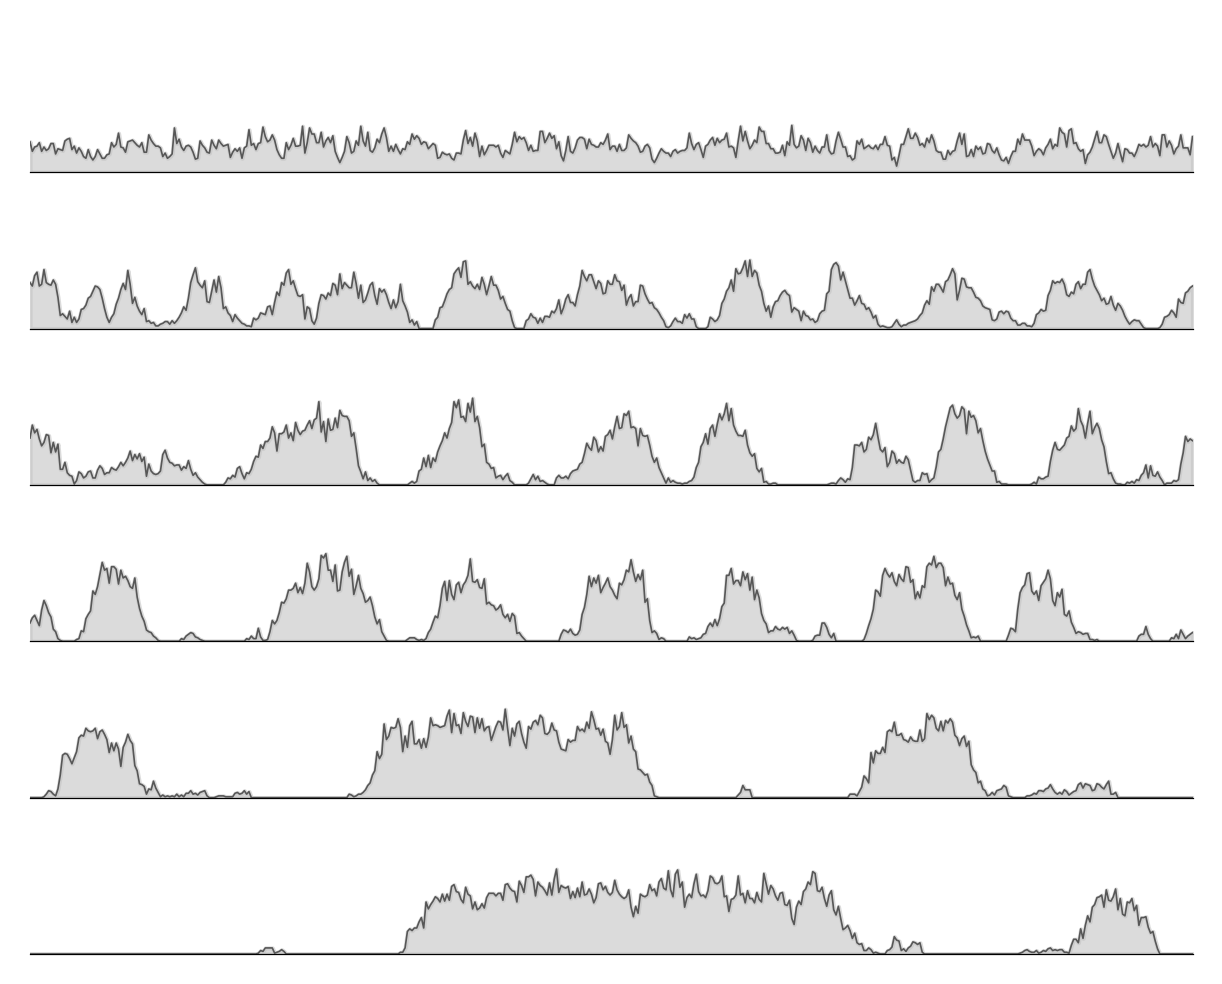

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
from scipy.ndimage import label
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# ==========================================
# 1. Helper Function Definitions
# ==========================================

def count_nucleus(rhoz, min_len=3):
    threshold = np.mean(rhoz)
    mask = rhoz > threshold
    labeled, n_features = label(mask)
    
    if n_features == 0:
        return 0

    sizes = [np.sum(labeled == i) for i in range(1, n_features + 1)]
    if mask[0] and mask[-1]:
        start_id = labeled[0]
        end_id = labeled[-1]
        if start_id != end_id:
            merged_size = sizes[start_id - 1] + sizes[end_id - 1]
            sizes[start_id - 1] = merged_size
            sizes[end_id - 1] = 0
    valid_count = sum(1 for s in sizes if s >= min_len)
    
    return valid_count

def get_density_profile(u, frame_idx, nbins=500):
    """
    Calculate 1D density profile along Z-axis using np.histogram for speed.
    """
    ts = u.trajectory[frame_idx]
    box = ts.dimensions
    lenx, leny, lenz = box[0], box[1], box[2]
    zmin, zmax = -lenz/2, lenz/2
    
    # Get atom positions and masses
    positions = ts.positions[:, 2] # Z-coordinates only
    masses = u.atoms.masses
    
    # Use histogram for fast binning (much faster than looping)
    hist, edges = np.histogram(positions, bins=nbins, range=(zmin, zmax), weights=masses)
    
    # Convert to density: mass / volume
    # Factor 6.02214e-1 handles unit conversion if needed (matches your original logic)
    dz = (zmax - zmin) / nbins
    rhoz = hist / (lenx * leny * dz * 6.02214e-1) 
    
    axisz = (edges[:-1] + edges[1:]) / 2 # Bin centers
    return axisz, rhoz

# ==========================================
# 2. Main Plotting Function
# ==========================================

def plot_droplet_growth_fusion(param, irep, t_list=[0, 1, 10, 100, 900]):
    # --- File Paths ---
    file_path_init = '../rg/traj_fusion/poly50/{}/fusion_initial_{}'.format(param, irep)
    file_path_fina = '../rg/traj_fusion/poly50/{}/fusion_final_{}'.format(param, irep)
    
    # --- Load Trajectories ---
    print("Loading trajectories...")
    try:
        u_init = mda.Universe(file_path_init + '.gsd', file_path_init + '.dcd', pbc=True)
        u_fina = mda.Universe(file_path_fina + '.gsd', file_path_fina + '.dcd', pbc=True)
    except Exception as e:
        print(f"Error loading files: {e}")
        return

    # --- Pre-calculate Data ---
    plot_data = [] 
    
    print("Processing frames...")
    for t_snapshot in t_list:
        # Determine trajectory and frame
        if t_snapshot < 10:
            u = u_init
            frame = int(t_snapshot / 0.01)
        else:
            u = u_fina
            frame = int(t_snapshot - 10) 
        
        # Boundary check
        if frame >= len(u.trajectory):
            frame = len(u.trajectory) - 1
            
        axisz, rhoz = get_density_profile(u, frame)
        n_drops = count_nucleus(rhoz)
        plot_data.append({
            'time': t_snapshot,
            'x': axisz,
            'y': rhoz,
            'n': n_drops
        })

    # ==========================================
    # 3. Plot Configuration (Default Fonts)
    # ==========================================
    # Removed explicit font settings to use system defaults
    plt.rcParams['axes.linewidth'] = 1.0

    # Colors
    PROFILE_LINE = "#575757"  # Deep Teal
    PROFILE_FILL = "#C4C4C4"  # Soft Mint
    CMAP_NAME = 'Blues'       # Timeline colormap
    cmap = plt.get_cmap(CMAP_NAME)
    
    # Setup Figure and GridSpec
    fig = plt.figure(figsize=(5, 4), dpi=300)
    
    # Modified width_ratios: [0.25, 6] creates a much narrower left strip
    gs = fig.add_gridspec(nrows=len(t_list), ncols=1, 
                          wspace=0.05, hspace=0.1)

    # Create Axes
    ax_plots = [fig.add_subplot(gs[i, 0]) for i in range(len(t_list))] # Right density plots
    # ==========================================
    # 5. Draw Right Density Profiles
    # ==========================================
    zmin, zmax = plot_data[0]['x'][0], plot_data[0]['x'][-1]
    
    for i, ax in enumerate(ax_plots):
        x = plot_data[i]['x']
        y = plot_data[i]['y']
        
        # Plotting
        ax.fill_between(x, 0, y, color=PROFILE_FILL, alpha=0.6, zorder=1)
        ax.plot(x, y, color=PROFILE_LINE, linewidth=0.4, zorder=2)
        
        # Styling
        ax.set_ylim(0, 1300) 
        ax.set_xlim(zmin, zmax)
        ax.set_yticks([]) # Hide Y ticks
        
        # Despining
        for spine in ax.spines.values():
            spine.set_linewidth(0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        ax.set_xticks([])
        # if i != len(t_list) - 1:
        #     ax.set_xticks([])
        #     ax.spines['bottom'].set_visible(False)
        # else:
        #     ax.set_xlabel('z (nm)', fontsize=10, weight='bold')
        #     ax.tick_params(axis='x', direction='in', length=3)

    # Save
    save_path = "../../figures/diffusion/new_plot/snapshot.svg"
    plt.savefig(save_path, format="svg", bbox_inches='tight')
    plt.show()
    # print(f"Figure saved to {save_path}")

plot_droplet_growth_fusion('des_0.20_0.12_0.00', 4, t_list = [0, 1, 5, 10, 100, 1000])